In [1]:
import random 
from random import sample, seed, shuffle
import numpy as np
import pandas as pd
import os
import six
from rdkit import rdBase
from rdkit import RDLogger


# Suppress RDKit warnings
rdBase.DisableLog('rdApp.*')
RDLogger.DisableLog('rdApp.*')

#utility functions : prepare the data 
from model_fp_selection.lib.utils import prepare_df_morgan, prepare_df_rdkit, swap_identical_ligands, prepare_df_chemeleon
from model_fp_selection.lib.utils import drop_duplicates, average_duplicates, calc_desc

#utility functions : CV and results 
from model_fp_selection.lib.utils import obtain_metrics, plot_cv_results
from model_fp_selection.lib.utils import df_split, get_indices, get_indices_doi, get_indices_scaff
from model_fp_selection.lib.utils import generate_scaffold, scaffold_to_smiles
from model_fp_selection.lib.utils import ligands_permutation, cross_validation, prepare_train_set


from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, PredictionErrorDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import MinMaxScaler

#Encoding categorical Data
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Regressors
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Pipelines and other model constructions
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Visualization
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

#np.random.seed(42)
#seed(42)

#Specific to Scaffold Splitting
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import defaultdict
import pickle as pkl
import time
from tqdm import tqdm
import seaborn as sns

from itertools import *

from model_fp_selection.lib.cross_val_both_models import cross_val_2_models

from model_fp_selection.chemeleon_fingerprint import CheMeleonFingerprint

In [2]:
import umap

In [3]:
metals= pd.read_csv("ruthenium_complexes_dataset.csv", dtype={'L1': str, 'L2': str, 'L3': str})
#metals_morgan = prepare_df_morgan(metals, 2, 1024)
#metals_rdkit = prepare_df_rdkit(metals, nbits=2048)


In [4]:
metals_morgan = prepare_df_morgan(metals, 2, 1024)
metals_rdkit = prepare_df_rdkit(metals, nbits=2048)

In [5]:
l=len(metals)
metals_chemeleon_1 = prepare_df_chemeleon(metals[0:int(0.33*l)])


In [6]:
metals_chemeleon_2 = prepare_df_chemeleon(metals[int(0.33*l):int(0.66*l)])

In [7]:
metals_chemeleon_3 = prepare_df_chemeleon(metals[int(0.66*l):l])

In [5]:
metals_chemeleon = pd.concat([metals_chemeleon_1, metals_chemeleon_2, metals_chemeleon_3], ignore_index=True)
metals_chemeleon = average_duplicates(metals_chemeleon, 'Ligands_Dict', 'pIC50')

NameError: name 'metals_chemeleon_1' is not defined

In [24]:
metals_morgan = average_duplicates(metals_morgan, 'Ligands_Dict', 'pIC50')
metals_rdkit = average_duplicates(metals_rdkit, 'Ligands_Dict', 'pIC50')


Length of training dataset after cleaning duplicates, before adding permutations : 718
Length of training dataset after cleaning duplicates, before adding permutations : 718


In [6]:
metals_desc = calc_desc(metals_rdkit)

In [11]:
from sklearn.decomposition import PCA

In [25]:
X_desc = metals_desc['Descriptors']
X_desc = X_desc.tolist()
X_desc = np.array(X_desc)
scaler=StandardScaler()
X_desc = scaler.fit_transform(X_desc)

X_desc.shape

(718, 600)

In [26]:
X_rdkit = metals_rdkit['Fingerprint']
X_rdkit = np.array(X_rdkit.tolist())
X_rdkit.shape

(718, 2048)

In [27]:
X_morgan = metals_morgan['Fingerprint']
X_morgan = np.array(X_morgan.tolist())
X_morgan.shape

(718, 1024)

In [76]:
X_chemeleon = metals_chemeleon['Descriptors']
X_chemeleon = X_chemeleon.tolist()
X_chemeleon = np.array(X_chemeleon,)
scaler=StandardScaler()
X_chemeleon = scaler.fit_transform(X_chemeleon)
X_chemeleon.shape

(718, 6144)

In [29]:
y = np.array(metals_rdkit['pIC50'].tolist())

In [29]:
dict_explained_variance = {'Encoding':[],'Explained variance':[], 'Total explained variance':[], 'Explained variance ratio':[]}

In [30]:
n_components = 2

pca_desc = PCA(n_components).fit(X_desc)
X_desc_pca = pca_desc.transform(X_desc)
dict_explained_variance['Explained variance'].append(pca_desc.explained_variance_)
dict_explained_variance['Total explained variance'].append(pca_desc.explained_variance_.sum())
dict_explained_variance['Encoding'].append('Descriptors')
dict_explained_variance['Explained variance ratio'].append(pca_desc.explained_variance_ratio_)

pca_rdkit = PCA(n_components).fit(X_rdkit)
X_rdkit_pca = pca_rdkit.transform(X_rdkit)
dict_explained_variance['Explained variance'].append(pca_rdkit.explained_variance_)
dict_explained_variance['Total explained variance'].append(pca_rdkit.explained_variance_.sum())
dict_explained_variance['Encoding'].append('RDKit FP')
dict_explained_variance['Explained variance ratio'].append(pca_rdkit.explained_variance_ratio_)

pca_morgan = PCA(n_components).fit(X_morgan)
X_morgan_pca = pca_morgan.transform(X_morgan)
dict_explained_variance['Explained variance'].append(pca_morgan.explained_variance_)
dict_explained_variance['Total explained variance'].append(pca_morgan.explained_variance_.sum())
dict_explained_variance['Encoding'].append('Morgan FP')
dict_explained_variance['Explained variance ratio'].append(pca_morgan.explained_variance_ratio_)

pca_chemeleon = PCA(n_components).fit(X_chemeleon)
X_chemeleon_pca = pca_chemeleon.transform(X_chemeleon)
dict_explained_variance['Explained variance'].append(pca_chemeleon.explained_variance_)
dict_explained_variance['Total explained variance'].append(pca_chemeleon.explained_variance_.sum())
dict_explained_variance['Encoding'].append('Chemeleon FP')
dict_explained_variance['Explained variance ratio'].append(pca_chemeleon.explained_variance_ratio_)

In [27]:
explained_variance_df = pd.DataFrame(dict_explained_variance)
explained_variance_df

Encoding                       Explained variance  \
0   Descriptors   [65.51754344728626, 49.94821951161903]   
1      RDKit FP  [321.06340483215007, 92.47372900060202]   
2     Morgan FP   [9.167650597416452, 6.104251530448722]   
3  Chemeleon FP                     [377.12143, 258.596]   

   Total explained variance                    Explained variance ratio  
0                115.465763  [0.14192254530753726, 0.10819664587046092]  
1                413.537134    [0.3501328840960643, 0.1008464152276268]  
2                 15.271902  [0.16272141031934984, 0.10834754307265884]  
3                635.717407                  [0.071203664, 0.048825078]

### PCA colored by pIC50 value

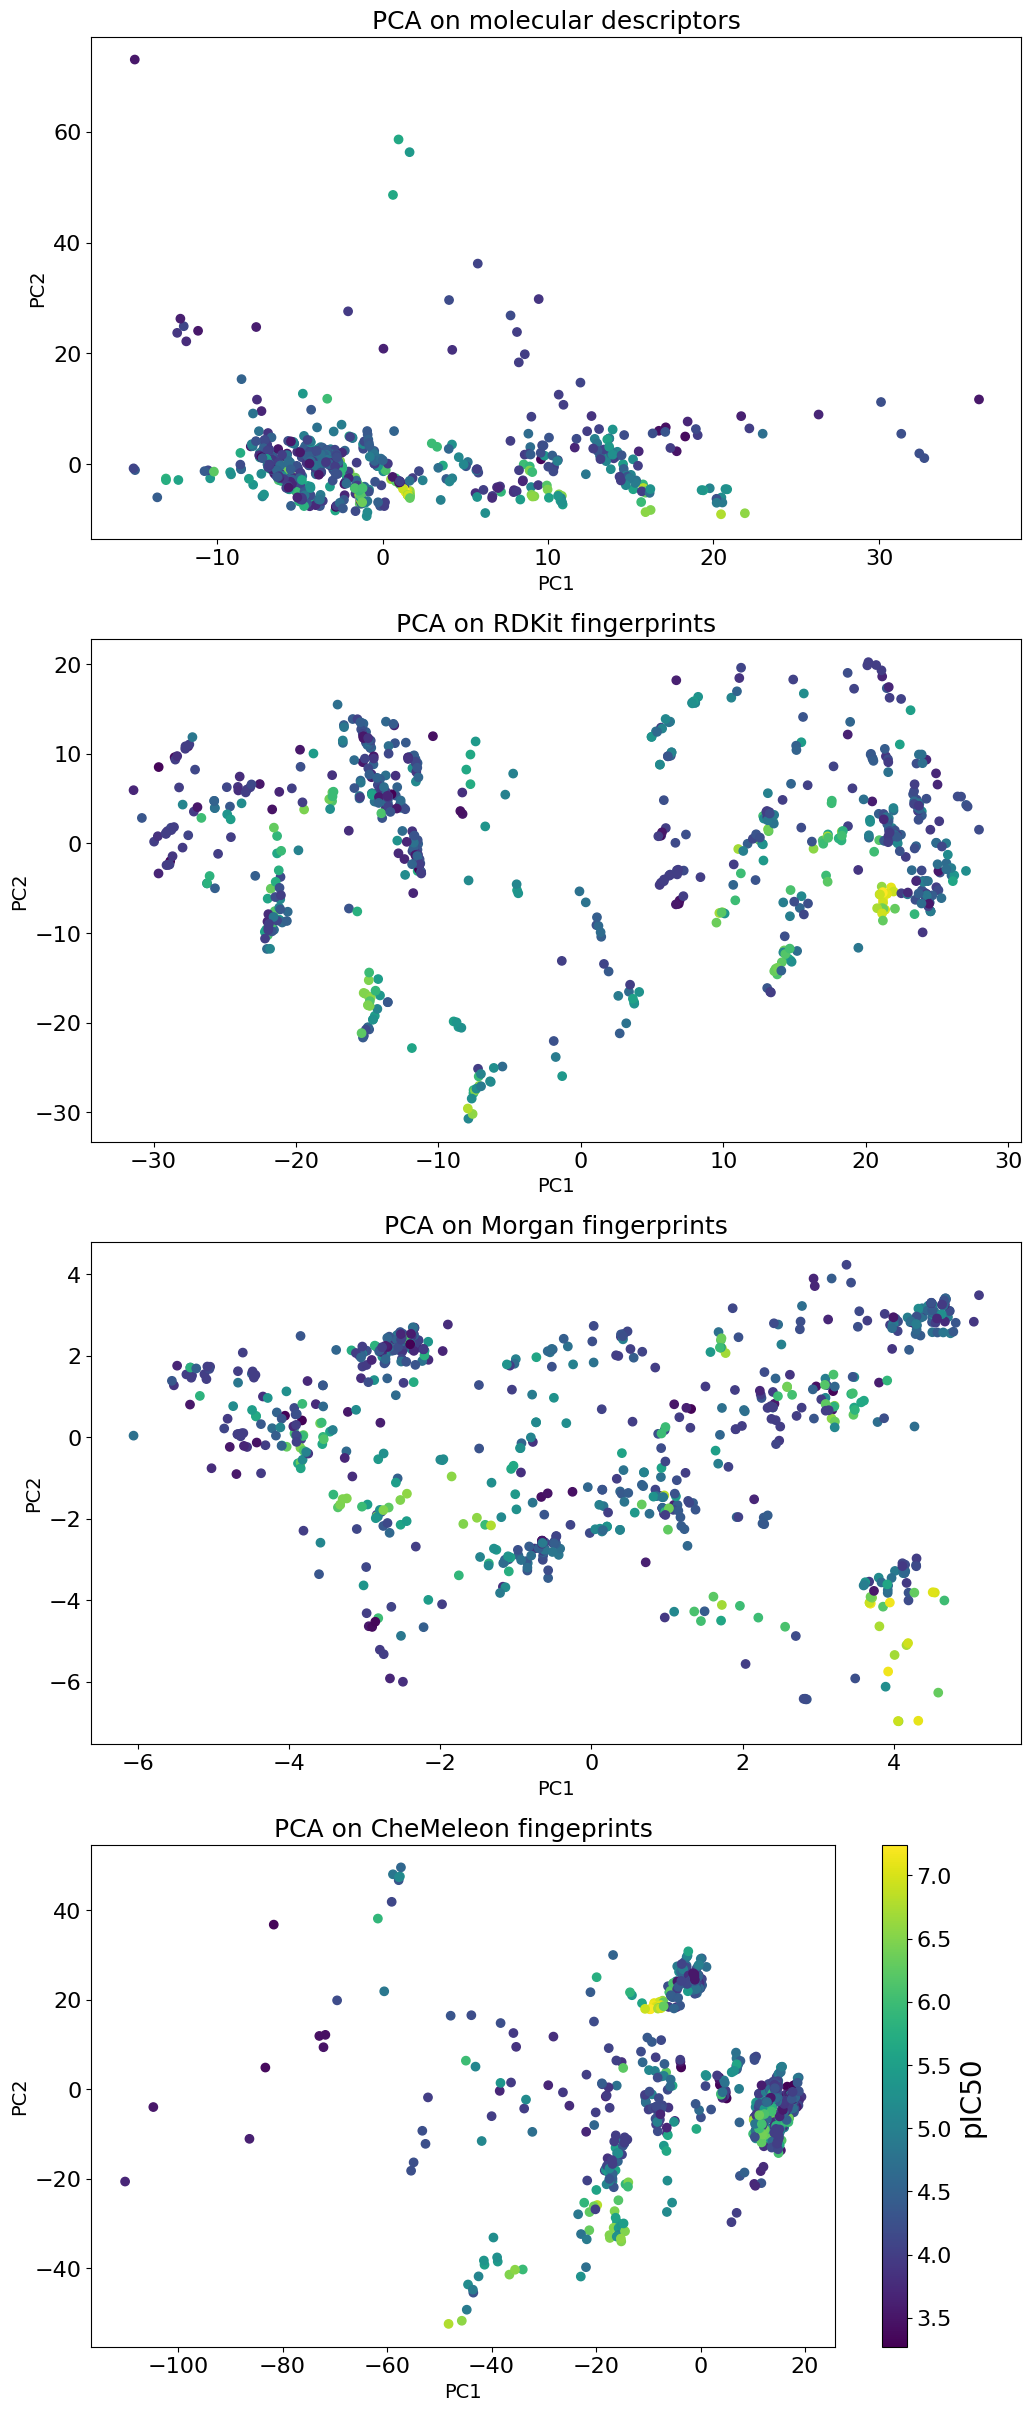

In [149]:
plt.figure(figsize=(12,30))

# Descriptors
plt.subplot(4,1,1)
plt.scatter(X_desc_pca[:,0], X_desc_pca[:,1], c=y, cmap="viridis")
#plt.ylim(-10, 30) # Use this to zoom on the descriptors cluster
plt.title("PCA on molecular descriptors", size=18)
plt.xlabel("PC1",size=14); plt.ylabel("PC2",size=14)

# Fingerprints
plt.subplot(4,1,2)
plt.scatter(X_rdkit_pca[:,0], X_rdkit_pca[:,1], c=y, cmap="viridis")
plt.title("PCA on RDKit fingerprints",size=18)
plt.xlabel("PC1",size=14); plt.ylabel("PC2",size=14)

plt.subplot(4,1,3)
plt.scatter(X_morgan_pca[:,0], X_morgan_pca[:,1], c=y, cmap="viridis")
plt.title("PCA on Morgan fingerprints",size=18)
plt.xlabel("PC1",size=14); plt.ylabel("PC2",size=14)

plt.subplot(4,1,4)
plt.scatter(X_chemeleon_pca[:,0], X_chemeleon_pca[:,1], c=y, cmap="viridis")
plt.title("PCA on CheMeleon fingeprints",size=18)
plt.xlabel("PC1",size=14); plt.ylabel("PC2",size=14)

plt.colorbar(label="pIC50")
plt.show()

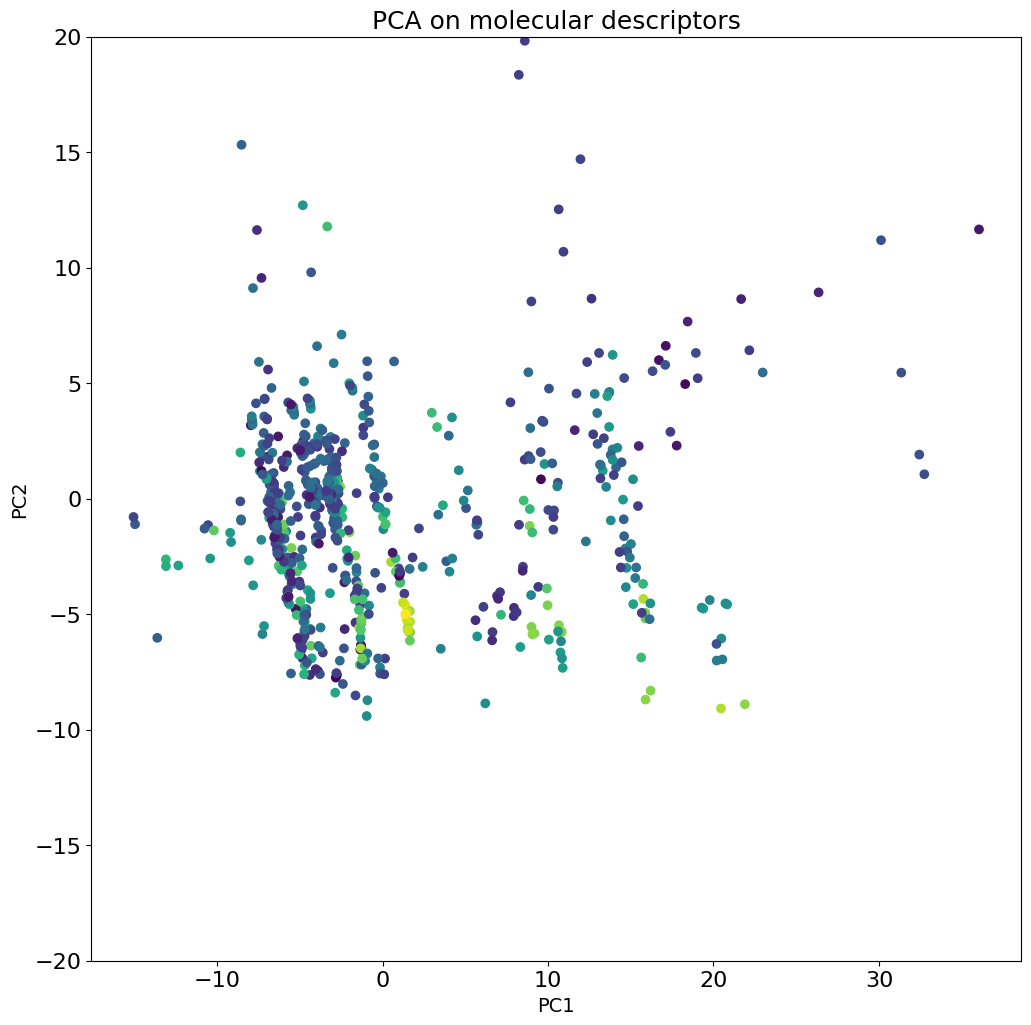

In [29]:
plt.figure(figsize=(12,12))
plt.scatter(X_desc_pca[:,0], X_desc_pca[:,1], c=y, cmap="viridis")
plt.ylim(-20, 20) # Use this to zoom on the descriptors cluster
plt.title("PCA on molecular descriptors", size=18)
plt.xlabel("PC1",size=14); plt.ylabel("PC2",size=14)
#plt.colorbar(label="pIC50")
plt.show()

### Let's see where our synthesized complexes locate on the PCA plot

#### Molecular descriptors

In [12]:
synth = pd.read_csv('synthesized_complexes.csv')
n_s = len(synth)
synth['IC50'] = [5.25, 4.20, 4.15, 6.08, 5.90, 4.30, 5.69]

synth_desc = prepare_df_rdkit(synth)
synth_desc = synth_desc.drop(columns=['IC50', 'pIC50'])
synth_desc = calc_desc(synth_desc)

In [13]:
synth

L1  \
0  C1(C2=CC=CC=C2)=CC=NC3=C1C=CC4=C3N=CC=C4C5=CC=...   
1                           C1(C2=NC=CC=C2)=NC=CC=C1   
2                           C1(C2=NC=CC=C2)=NC=CC=C1   
3                        C12=NC=CC=C1C=CC3=C2N=CC=C3   
4                        C12=NC=CC=C1C=CC3=C2N=CC=C3   
5                           C1(C2=CC=CC=N2)=NC=CC=C1   
6                        C12=NC=CC=C1C=CC3=C2N=CC=C3   

                                                  L2  \
0  C1(C2=CC=CC=C2)=CC=NC3=C1C=CC4=C3N=CC=C4C5=CC=...   
1                           C1(C2=NC=CC=C2)=NC=CC=C1   
2                           C1(C2=NC=CC=C2)=NC=CC=C1   
3                        C12=NC=CC=C1C=CC3=C2N=CC=C3   
4                        C12=NC=CC=C1C=CC3=C2N=CC=C3   
5                           C1(C2=CC=CC=N2)=NC=CC=C1   
6                        C12=NC=CC=C1C=CC3=C2N=CC=C3   

                                                  L3  IC50  
0  COC(C=C1)=CC=C1C2=NN(C3=NC=CC=C3)C(C4=CC=CC=C4...  5.25  
1  O=[N+](C1=CC=C(C2=NN(C(C3=CC=CC=C3)=C2)C4=NC=C...  4.20  
2  O=C(C(C=C1)=CC=C1N2C(C3=CC=C(N(C4=CC=CC=C4)C5=...  4.15  
3                BrC(C=C1)=CC(O)=C1C2=NC3=CC=CC=C3S2  6.08  
4           OC(C=C(N(CC)CC)C=C1)=C1C2=NC3=CC=CC=C3S2  5.90  
5           OC1=C(N=C(/C=C/C2=CN=CC=C2)C=C3)C3=CC=C1  4.30  
6       OC1=C(N=C(/C=C/C2=CC=C(Br)C=C2)C=C3)C3=CC=C1  5.69

In [14]:
X_synth_desc = synth_desc['Descriptors']
X_synth_desc = X_synth_desc.tolist()
X_synth_desc = np.array(X_synth_desc)
scaler=StandardScaler()
X_synth_desc = scaler.fit_transform(X_synth_desc)
X_synth_desc.shape

(7, 600)

In [21]:
X_synth_desc_pca = pca_desc.transform(X_synth_desc)

plt.figure(figsize=(12,12))
plt.scatter(X_desc_pca[:,0], X_desc_pca[:,1], c=y, cmap="viridis", alpha=0.75, s=20)
plt.scatter(X_synth_desc_pca[:,0], X_synth_desc_pca[:,1], c=synth['IC50'].tolist(), cmap='viridis', marker='D', s=80)
plt.title("PCA on Molecular descriptors",size=18)
plt.xlabel("PC1",size=14); plt.ylabel("PC2",size=14)
#plt.ylim(-10, 10)

plt.colorbar(label="pIC50")
plt.show()

NameError: name 'pca_desc' is not defined

#### RDKit fingerprints

In [15]:

synth_rdkit = prepare_df_rdkit(synth)
synth_rdkit = synth_rdkit.drop(columns=['IC50', 'pIC50'])

In [16]:
X_synth_rdkit = synth_rdkit['Fingerprint']
X_synth_rdkit = X_synth_rdkit.tolist()
X_synth_rdkit = np.array(X_synth_rdkit)
scaler=StandardScaler()
#X_synth_rdkit = scaler.fit_transform(X_synth_rdkit)
X_synth_rdkit.shape

(7, 2048)

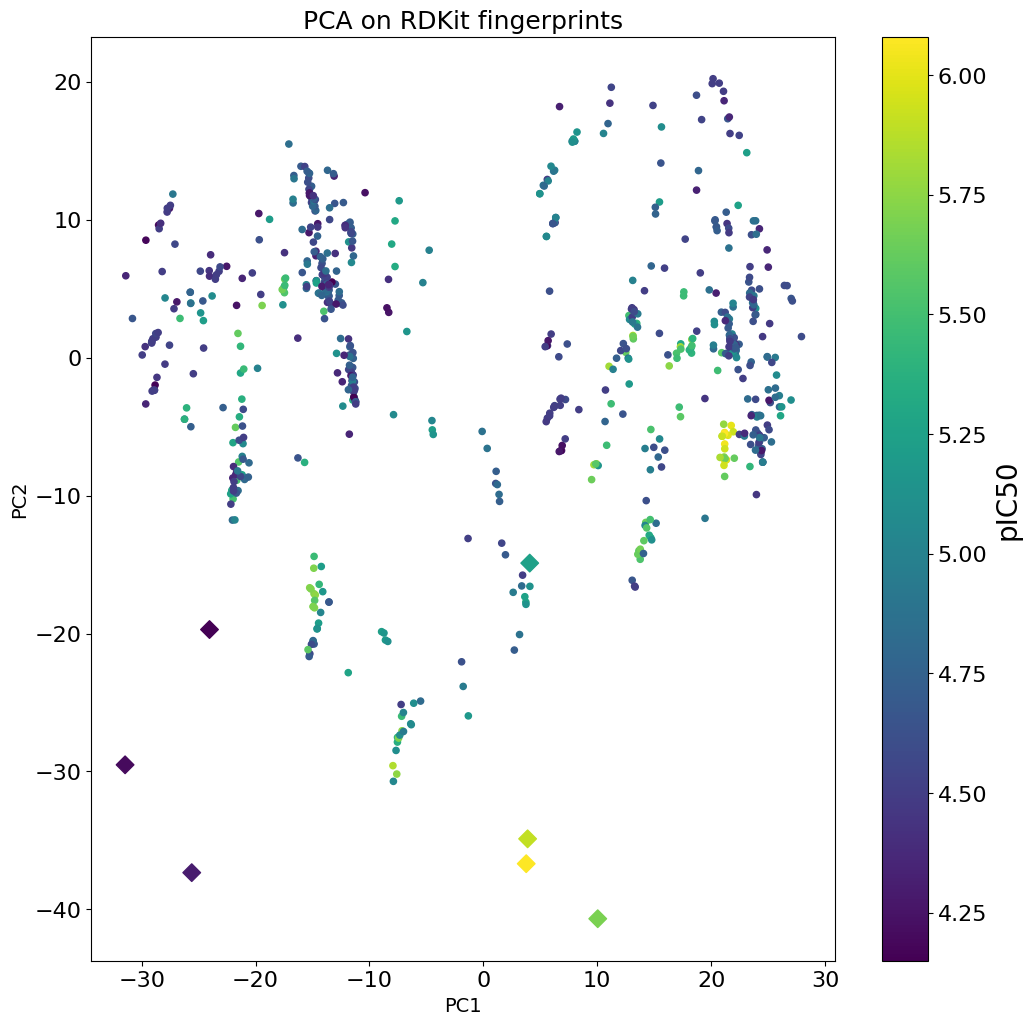

In [42]:
X_synth_rdkit_pca = pca_rdkit.transform(X_synth_rdkit)

plt.figure(figsize=(12,12))
plt.scatter(X_rdkit_pca[:,0], X_rdkit_pca[:,1], c=y, cmap="viridis", alpha = 1, s = 20)
plt.scatter(X_synth_rdkit_pca[:,0], X_synth_rdkit_pca[:,1], c=synth['IC50'].tolist(), cmap='viridis', marker='D', s=80)
plt.title("PCA on RDKit fingerprints",size=18)
plt.xlabel("PC1",size=14); plt.ylabel("PC2",size=14)
#plt.ylim(-10, 10)

plt.colorbar(label="pIC50")
plt.show()

#### Morgan FP

In [17]:
synth_morgan = prepare_df_morgan(synth, 2, 1024)
synth_morgan = synth_morgan.drop(columns=['IC50', 'pIC50'])

In [18]:
X_synth_morgan = synth_morgan['Fingerprint']
X_synth_morgan = X_synth_morgan.tolist()
X_synth_morgan = np.array(X_synth_morgan)
scaler=StandardScaler()
#X_synth_morgan = scaler.fit_transform(X_synth_morgan)
X_synth_morgan.shape

(7, 1024)

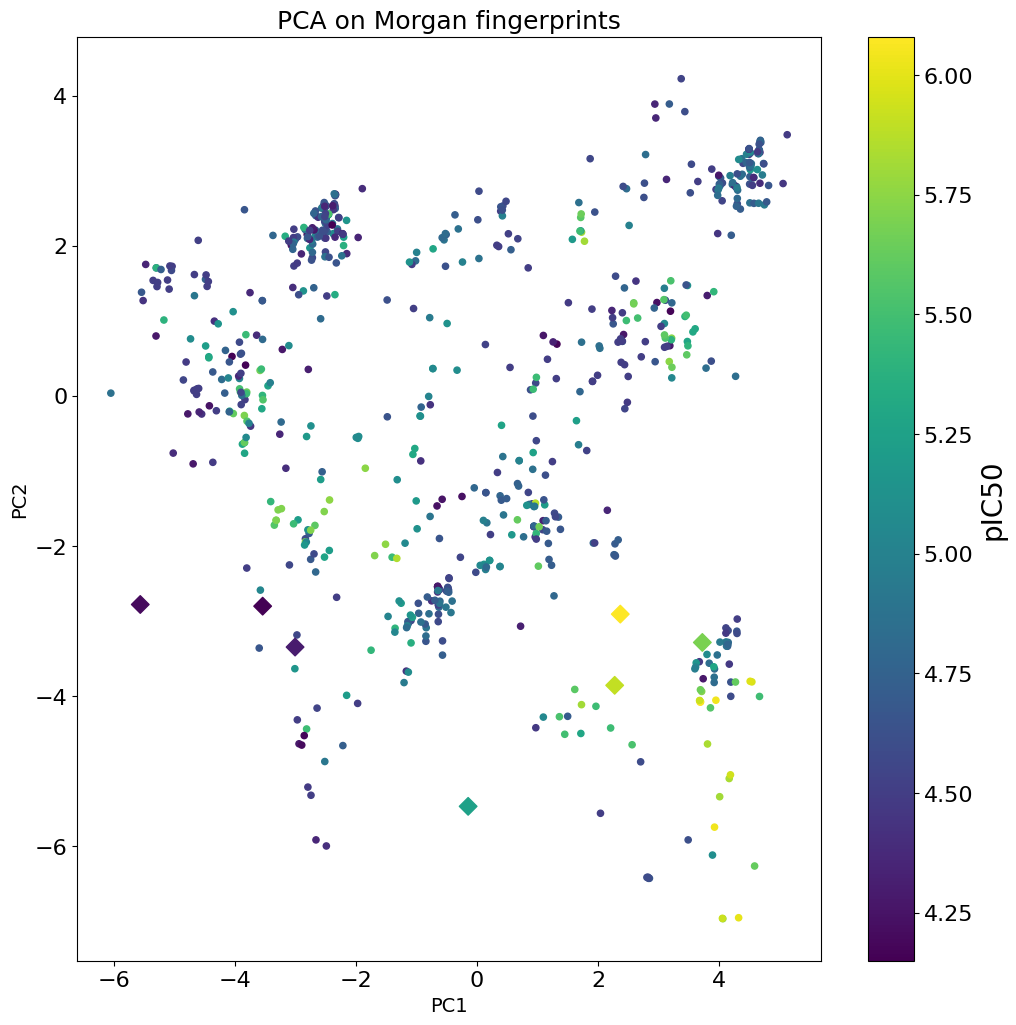

In [39]:
X_synth_morgan_pca = pca_morgan.transform(X_synth_morgan)

plt.figure(figsize=(12,12))
plt.scatter(X_morgan_pca[:,0], X_morgan_pca[:,1], c=y, cmap="viridis", s=20)
plt.scatter(X_synth_morgan_pca[:,0], X_synth_morgan_pca[:,1], c=synth['IC50'].tolist(), cmap='viridis', marker='D', s=80)
plt.title("PCA on Morgan fingerprints",size=18)
plt.xlabel("PC1",size=14); plt.ylabel("PC2",size=14)
#plt.ylim(-10, 10)

plt.colorbar(label="pIC50")
plt.show()

#### CheMeleon FP

In [19]:
synth_chemeleon = prepare_df_chemeleon(synth)
synth_chemeleon = synth_chemeleon.drop(columns=['IC50', 'pIC50'])

In [74]:
X_synth_chemeleon = synth_chemeleon['Descriptors']

In [75]:
X_synth_chemeleon = X_synth_chemeleon.tolist()
X_synth_chemeleon = np.array(X_synth_chemeleon)
scaler=StandardScaler()
X_synth_chemeleon = scaler.fit_transform(X_synth_chemeleon)
X_synth_chemeleon.shape

(7, 6144)

In [62]:
X_synth_chemeleon_pca = pca_chemeleon.transform(X_synth_chemeleon)

NameError: name 'pca_chemeleon' is not defined

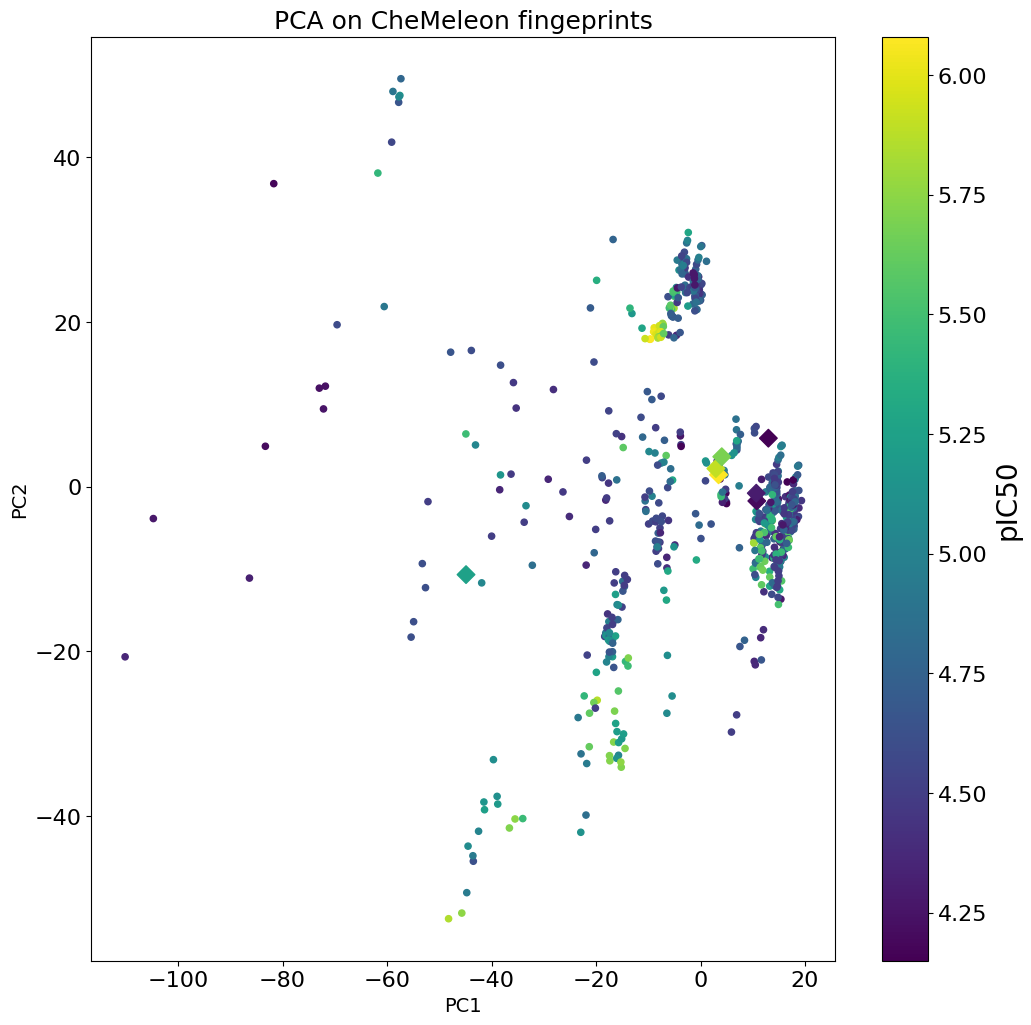

In [44]:
plt.figure(figsize=(12,12))
plt.scatter(X_chemeleon_pca[:,0], X_chemeleon_pca[:,1], c=y, cmap="viridis", s=20)
plt.scatter(X_synth_chemeleon_pca[:,0], X_synth_chemeleon_pca[:,1], c=synth['IC50'].tolist(), cmap='viridis', marker='D', s=80)
plt.title("PCA on CheMeleon fingeprints",size=18)
plt.xlabel("PC1",size=14); plt.ylabel("PC2",size=14)

plt.colorbar(label="pIC50")
plt.show()

### PCA colored by DOI

In [45]:
unique_dois = np.array(list(set(metals_desc['DOI'])))

doi_to_int = {d: i for i, d in enumerate(unique_dois)}
doi_numeric = np.array([doi_to_int[d] for d in metals_desc['DOI']])



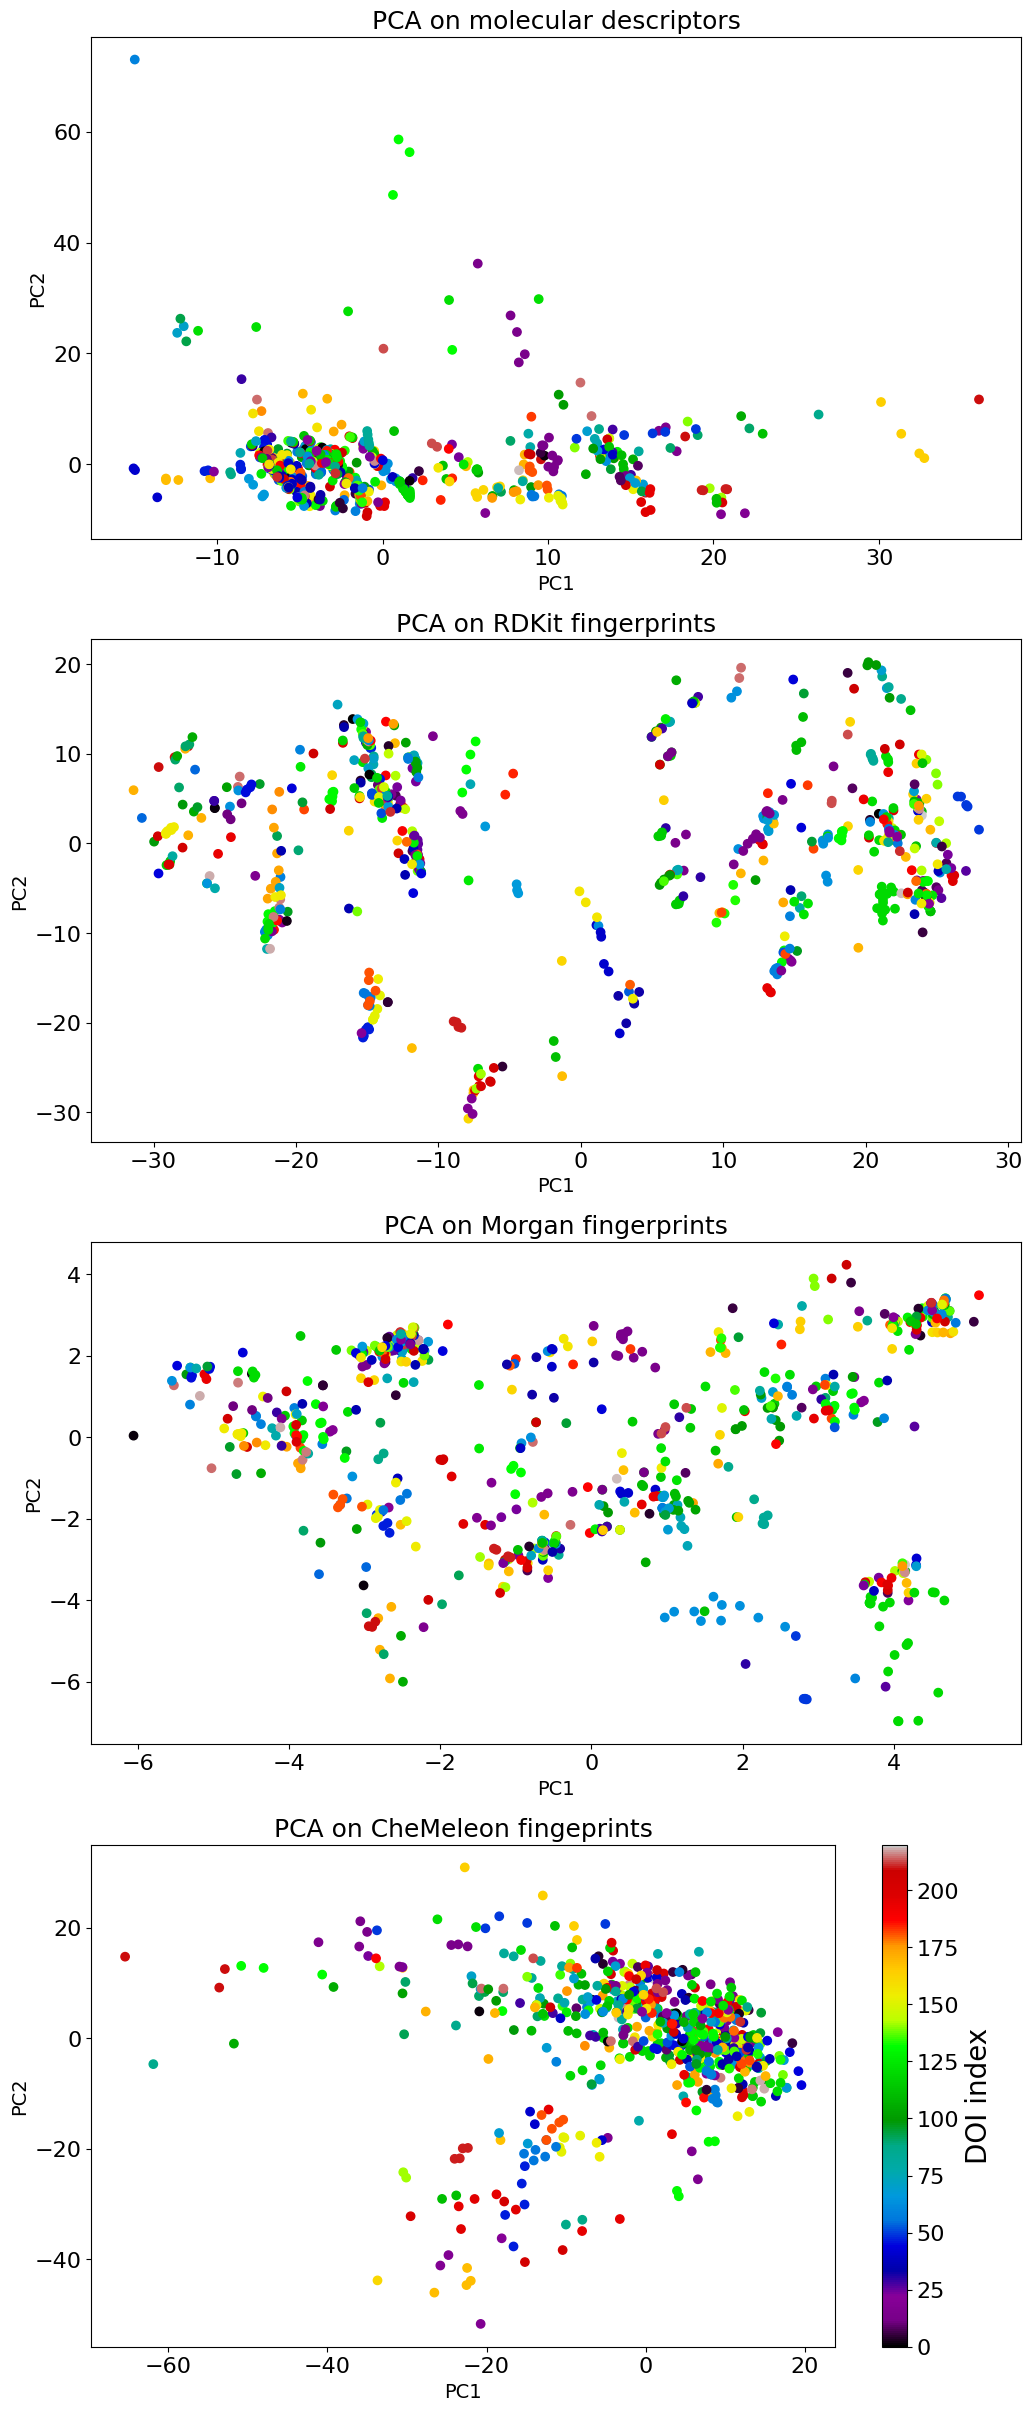

In [47]:
plt.figure(figsize=(12,30))

# Descriptors
plt.subplot(4,1,1)
plt.scatter(X_desc_pca[:,0], X_desc_pca[:,1], c=doi_numeric, cmap="nipy_spectral")
#plt.ylim(-10, 30) # Use this to zoom on the descriptors cluster
plt.title("PCA on molecular descriptors", size=18)
plt.xlabel("PC1",size=14); plt.ylabel("PC2",size=14)

# Fingerprints
plt.subplot(4,1,2)
plt.scatter(X_rdkit_pca[:,0], X_rdkit_pca[:,1], c=doi_numeric, cmap="nipy_spectral")
plt.title("PCA on RDKit fingerprints",size=18)
plt.xlabel("PC1",size=14); plt.ylabel("PC2",size=14)

plt.subplot(4,1,3)
plt.scatter(X_morgan_pca[:,0], X_morgan_pca[:,1], c=doi_numeric, cmap="nipy_spectral")
plt.title("PCA on Morgan fingerprints",size=18)
plt.xlabel("PC1",size=14); plt.ylabel("PC2",size=14)

plt.subplot(4,1,4)
plt.scatter(X_chemeleon_pca[:,0], X_chemeleon_pca[:,1], c=doi_numeric, cmap="nipy_spectral")
plt.title("PCA on CheMeleon fingeprints",size=18)
plt.xlabel("PC1",size=14); plt.ylabel("PC2",size=14)

plt.colorbar(label="DOI index")
plt.show()

# Trying UMAP

In [22]:
import umap

In [12]:
os.environ['PYTHONHASHSEED'] = '0'   # only needed in extreme cases
np.random.seed(42)
mapper = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    random_state=42,   # essential for reproducibility
    init='spectral',   # good deterministic-ish init (still uses random_state)
    n_jobs=1           # single thread lowers nondeterminism (slower)
)

In [77]:
umap_desc = mapper.fit(X_desc)
X_desc_umap = umap_desc.transform(X_desc)

In [31]:
umap_rdkit = mapper.fit(X_rdkit)
X_rdkit_umap = umap_rdkit.transform(X_rdkit)

In [78]:
len(X_desc_umap)

718

In [33]:
umap_morgan = mapper.fit(X_morgan)
X_morgan_umap = umap_morgan.transform(X_morgan)

In [34]:
umap_chemeleon = mapper.fit(X_chemeleon)
X_chemeleon_umap = umap_chemeleon.transform(X_chemeleon)

In [79]:
X_desc_umap_df = pd.DataFrame(X_desc_umap)

In [35]:

X_rdkit_umap_df = pd.DataFrame(X_rdkit_umap)
X_morgan_umap_df = pd.DataFrame(X_morgan_umap)
X_chemeleon_umap_df = pd.DataFrame(X_chemeleon_umap)

In [36]:

X_rdkit_umap_df.columns = ['UMAP1', 'UMAP2']
X_morgan_umap_df.columns = ['UMAP1', 'UMAP2']
X_chemeleon_umap_df.columns = ['UMAP1', 'UMAP2']

In [80]:
X_desc_umap_df.columns = ['UMAP1', 'UMAP2']

In [37]:
generated = pd.read_csv('generated_200k.csv')

In [38]:
import re
def parse_array_string(s):
    if pd.isna(s):
        return np.array([])           # or return np.nan if you prefer
    # replace newlines and repeated whitespace with single space, remove brackets
    clean = re.sub(r"[\[\]\n]+", " ", str(s)).strip()
    if clean == "":
        return np.array([])
    return np.fromstring(clean, sep=" ")

In [39]:
generated['Descriptors'] = generated['Descriptors'].apply(parse_array_string)

In [40]:
X_gen = generated['Descriptors']
X_gen = X_gen[X_gen.apply(lambda arr: not np.isnan(arr).any())]
X_gen = X_gen.tolist()
X_gen = np.array(X_gen)
scaler=StandardScaler()
X_gen = scaler.fit_transform(X_gen)

X_gen.shape


C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\sklearn\preprocessing\_data.py:1050: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


(199965, 600)

In [42]:
umap_generated = mapper.fit(X_gen)
X_gen_umap = umap_generated.transform(X_gen)

C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is like

In [43]:
X_gen_umap_df = pd.DataFrame(X_gen_umap)
X_gen_umap_df.columns = ['UMAP1', 'UMAP2']


In [44]:
gen_rdkit = pd.read_csv('dataset_encoded_to_RDKit_FP.csv')

In [47]:
import json
X_gen_rdkit = gen_rdkit['Fingerprint'].apply(json.loads)

X_gen_rdkit = np.stack(X_gen_rdkit.values)

X_gen_rdkit.shape


(186073, 2048)

In [48]:
umap_generated_rdkit = mapper.fit(X_gen_rdkit)
X_gen_umap_rdkit = umap_generated_rdkit.transform(X_gen_rdkit)
X_gen_umap_rdkit_df = pd.DataFrame(X_gen_umap_rdkit)
X_gen_umap_rdkit_df.columns = ['UMAP1', 'UMAP2']

C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [49]:
gen_morgan = pd.read_csv('dataset_encoded_to_Morgan_FP.csv')

In [50]:
X_gen_morgan = gen_morgan['Fingerprint'].apply(json.loads)

X_gen_morgan = np.stack(X_gen_morgan.values)

X_gen_morgan.shape


(200000, 1024)

In [51]:
umap_generated_morgan = mapper.fit(X_gen_morgan)
X_gen_umap_morgan = umap_generated_morgan.transform(X_gen_morgan)
X_gen_umap_morgan_df = pd.DataFrame(X_gen_umap_morgan)
X_gen_umap_morgan_df.columns = ['UMAP1', 'UMAP2']

C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\umap\spectral.py:5

In [52]:
X_gen_umap_chemeleon_df = pd.read_csv('UMAP_Chemeleon_200k.csv')

In [60]:
X_gen_umap_chemeleon_df = X_gen_umap_chemeleon_df[['UMAP1', 'UMAP2']]

In [61]:
X_gen_umap_chemeleon_df

UMAP1     UMAP2
0       13.105747  6.370789
1       -4.488335  2.273054
2       -1.137130  1.110353
3       13.536781  2.750191
4       12.776390  6.519130
...           ...       ...
199995  -2.836042  3.510727
199996  -5.864321  1.868639
199997  -3.210307  3.112567
199998  -2.278033  5.681632
199999  16.368683  2.760771

[200000 rows x 2 columns]

#### Adding the synthesized complexes

In [81]:
X_synth_desc_umap = umap_desc.transform(X_synth_desc)

In [82]:
X_synth_desc_umap = pd.DataFrame(X_synth_desc_umap)
X_synth_desc_umap.columns = ['UMAP1', 'UMAP2']

In [56]:
X_synth_rdkit_umap = umap_rdkit.transform(X_synth_rdkit)
X_synth_rdkit_umap = pd.DataFrame(X_synth_rdkit_umap)
X_synth_rdkit_umap.columns = ['UMAP1', 'UMAP2']

In [57]:
X_synth_morgan_umap = umap_morgan.transform(X_synth_morgan)
X_synth_morgan_umap = pd.DataFrame(X_synth_morgan_umap)
X_synth_morgan_umap.columns = ['UMAP1', 'UMAP2']

In [58]:
X_synth_chemeleon_umap = umap_chemeleon.transform(X_synth_chemeleon)
X_synth_chemeleon_umap = pd.DataFrame(X_synth_chemeleon_umap)
X_synth_chemeleon_umap.columns = ['UMAP1', 'UMAP2']

In [69]:
len(X_synth_desc)

7

#### Plotting

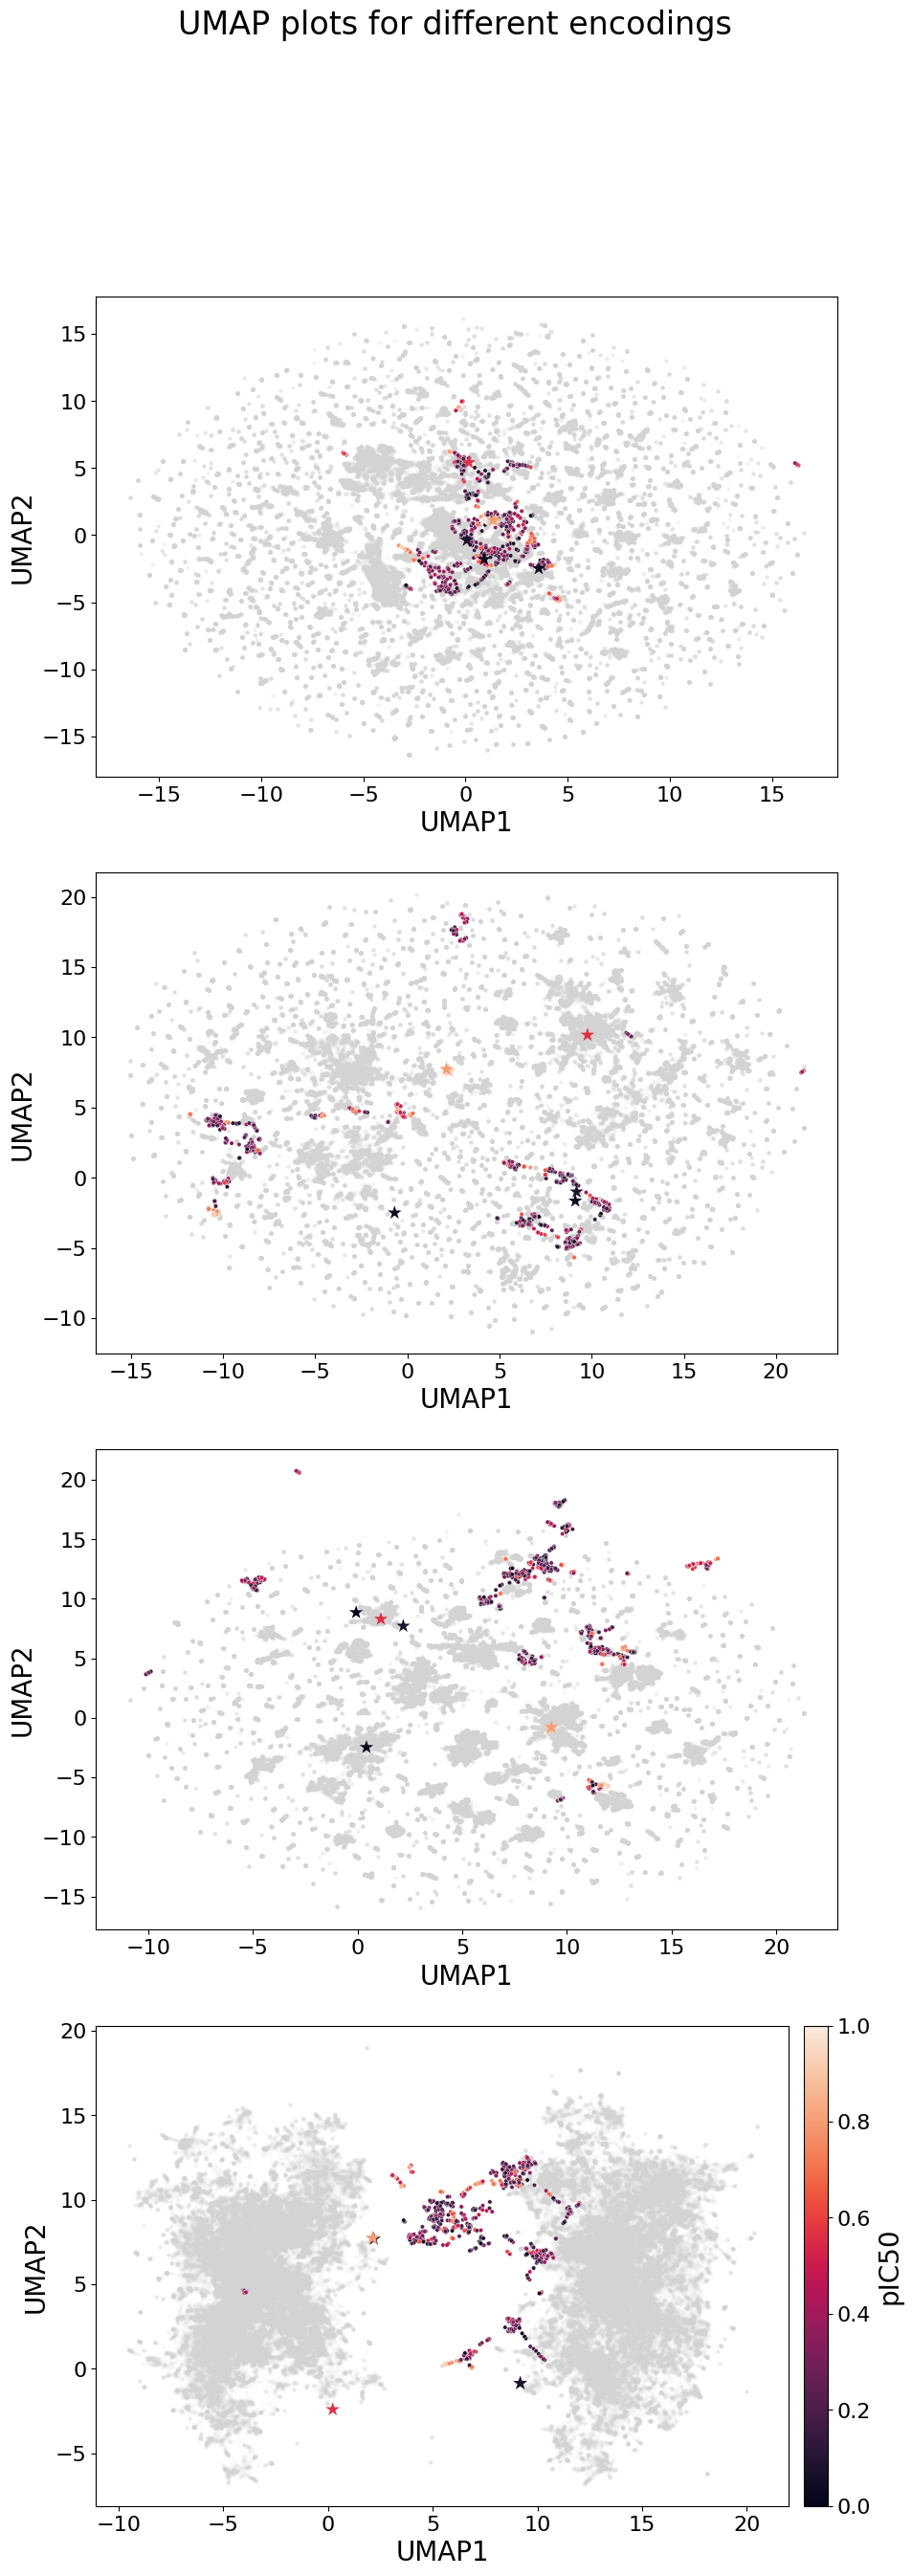

In [83]:
fig, axes = plt.subplots(4, 1, figsize=(10, 30))

fig.suptitle('UMAP plots for different encodings')
cmap = sns.color_palette('rocket', as_cmap=True)

sns.scatterplot(ax = axes[0], data=X_gen_umap_df, x='UMAP1', y='UMAP2', s=8, alpha=0.05, color='lightgray', legend=False)
sns.scatterplot(ax=axes[0], data=X_desc_umap_df, x='UMAP1', y='UMAP2', hue=metals_desc['pIC50'], palette=cmap, legend=False, s=10)
sns.scatterplot(ax=axes[0], data = X_synth_desc_umap, x='UMAP1', y='UMAP2', marker='*', edgecolor='none', s=120, hue=synth['IC50'], palette=cmap, legend=False, zorder=3)

sns.scatterplot(ax = axes[1], data=X_gen_umap_rdkit_df, x='UMAP1', y='UMAP2', s=8, alpha=0.05, color='lightgray', legend=False)
sns.scatterplot(ax=axes[1], data=X_rdkit_umap_df, x='UMAP1', y='UMAP2', hue=metals_rdkit['pIC50'], palette=cmap, legend=False, s=10)
sns.scatterplot(ax=axes[1], data = X_synth_rdkit_umap, x='UMAP1', y='UMAP2', marker='*', edgecolor='none', s=120, hue=synth['IC50'], palette=cmap, legend=False, zorder=3)

sns.scatterplot(ax = axes[2], data=X_gen_umap_morgan_df, x='UMAP1', y='UMAP2', s=8, alpha=0.05, color='lightgray', legend=False)
sns.scatterplot(ax=axes[2], data=X_morgan_umap_df, x='UMAP1', y='UMAP2', hue=metals_morgan['pIC50'], palette=cmap, legend=False, s=10)
sns.scatterplot(ax=axes[2], data = X_synth_morgan_umap, x='UMAP1', y='UMAP2', marker='*', edgecolor='none', s=120, hue=synth['IC50'], palette=cmap, legend=False, zorder=3)

sns.scatterplot(ax = axes[3], data=X_gen_umap_chemeleon_df, x='UMAP1', y='UMAP2', s=8, alpha=0.05, color='lightgray', legend=False)
sns.scatterplot(ax=axes[3], data=X_chemeleon_umap_df, x='UMAP1', y='UMAP2', hue=metals_chemeleon['pIC50'], palette=cmap, legend=False, s=10)
sns.scatterplot(ax=axes[3], data = X_synth_chemeleon_umap, x='UMAP1', y='UMAP2', marker='*',edgecolor='none', s=120, hue=synth['IC50'], palette=cmap, legend=False, zorder=3)


sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])  # required for colorbar
cbar = fig.colorbar(sm, ax=axes[3], orientation='vertical', fraction=0.046, pad=0.02)
cbar.set_label('pIC50')

plt.savefig('./umap_generated_200K_points.png', dpi=300)


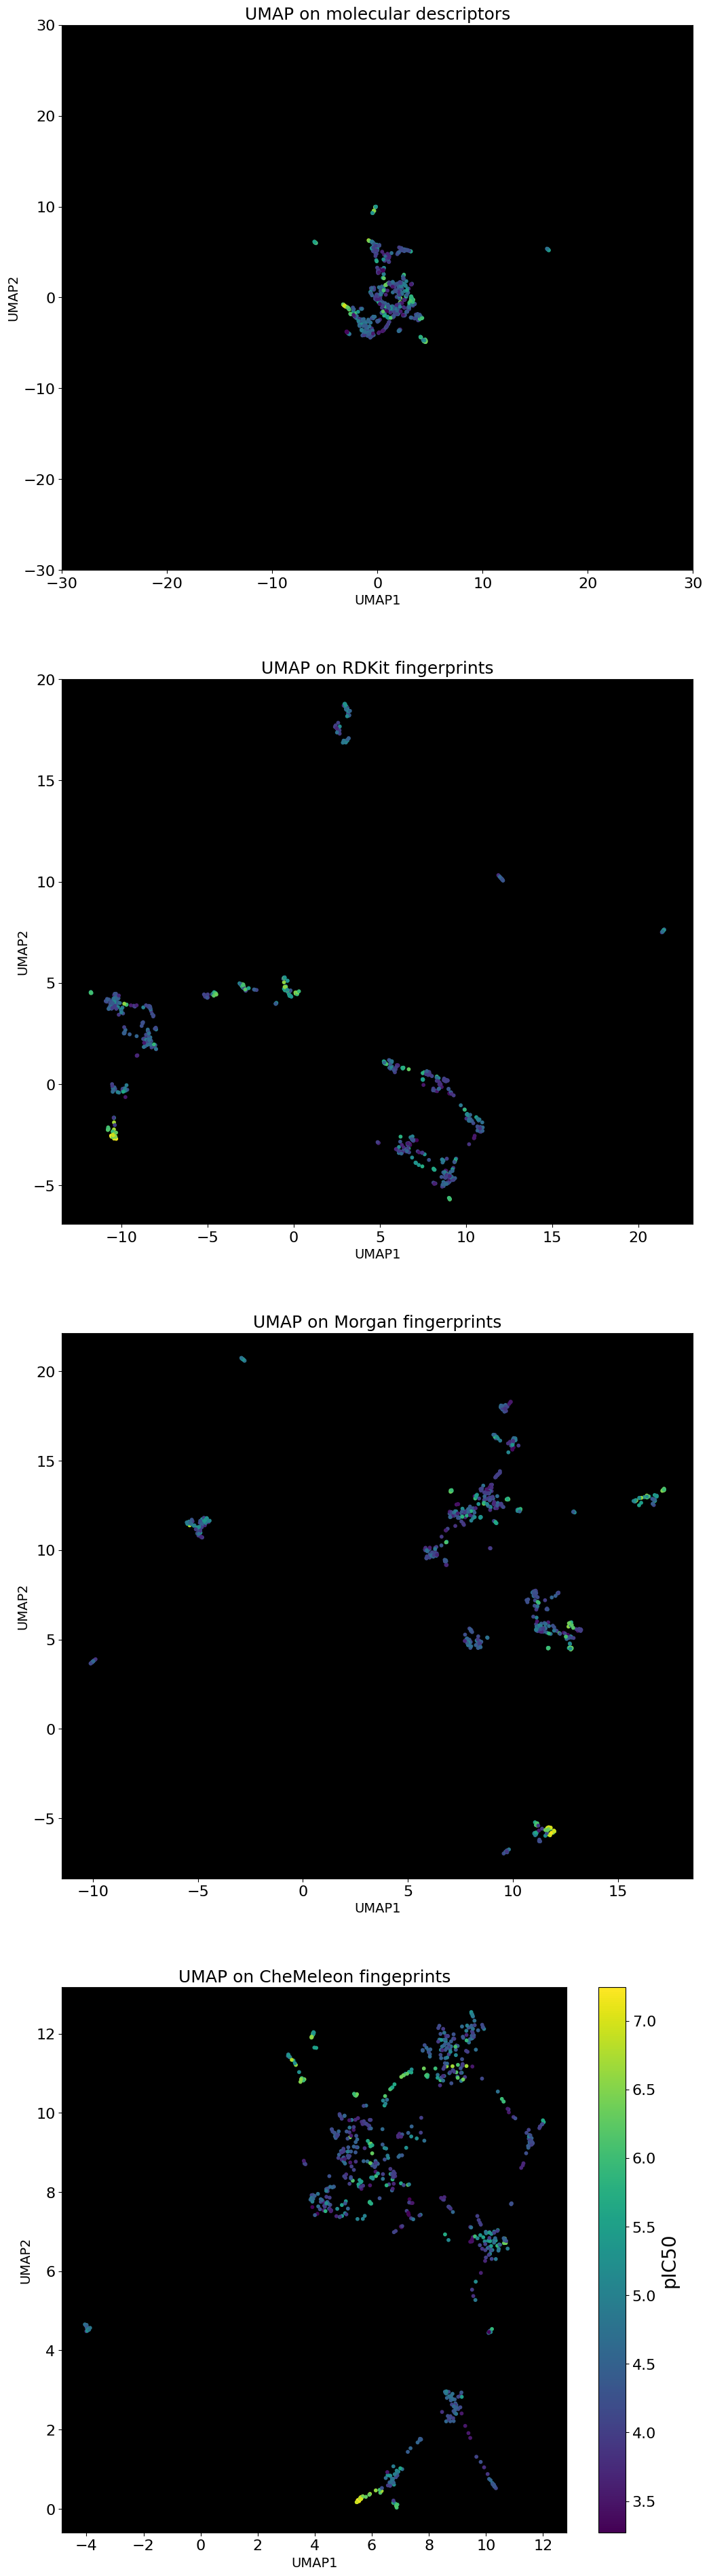

In [161]:
plt.figure(figsize=(12,48))

# Descriptors
plt.subplot(4,1,1, facecolor='black')
plt.scatter(X_desc_umap[:,0], X_desc_umap[:,1], c=metals_desc['pIC50'], cmap="viridis", s=10)
plt.ylim(-30, 30) # Use this to zoom on the descriptors cluster
plt.xlim(-30,30)
plt.title("UMAP on molecular descriptors", size=18)
plt.xlabel("UMAP1",size=14); plt.ylabel("UMAP2",size=14)
#ax.set_facecolor('black') 

# Fingerprints
plt.subplot(4,1,2, facecolor='black')
plt.scatter(X_rdkit_umap[:,0], X_rdkit_umap[:,1], c=y, cmap="viridis", s=10)
plt.title("UMAP on RDKit fingerprints",size=18)
plt.xlabel("UMAP1",size=14); plt.ylabel("UMAP2",size=14)

plt.subplot(4,1,3, facecolor='black')
plt.scatter(X_morgan_umap[:,0], X_morgan_umap[:,1], c=y, cmap="viridis", s=10)
plt.title("UMAP on Morgan fingerprints",size=18)
plt.xlabel("UMAP1",size=14); plt.ylabel("UMAP2",size=14)

plt.subplot(4,1,4, facecolor='black')
plt.scatter(X_chemeleon_umap[:,0], X_chemeleon_umap[:,1], c=y, cmap="viridis", s=10)
plt.title("UMAP on CheMeleon fingeprints",size=18)
plt.xlabel("UMAP1",size=14); plt.ylabel("UMAP2",size=14)

plt.colorbar(label="pIC50")
plt.show()

### Let's see where our synthesized complexes locate on the UMAP plot

In [63]:
X_synth_desc = synth_desc['Descriptors']
X_synth_desc = X_synth_desc.tolist()
X_synth_desc = np.array(X_synth_desc)
scaler=StandardScaler()
X_synth_desc = scaler.fit_transform(X_synth_desc)
X_synth_desc.shape


(7, 600)

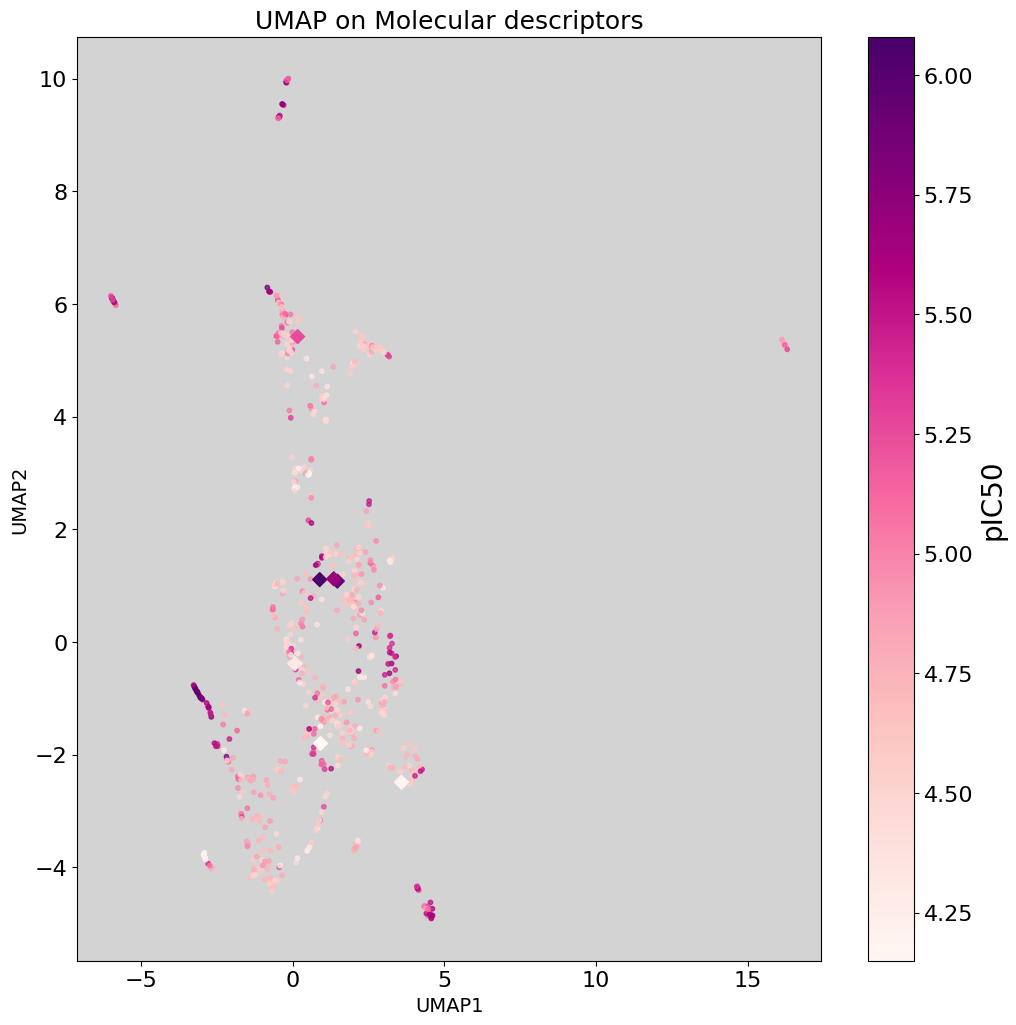

In [154]:
umap_desc = mapper.fit(X_desc)
X_desc_umap = umap_desc.transform(X_desc)

X_synth_desc_umap = umap_desc.transform(X_synth_desc)

plt.figure(figsize=(12,12))
ax = plt.gca()
plt.scatter(X_desc_umap[:,0], X_desc_umap[:,1], c=y, cmap="RdPu", alpha=0.75, s=10)
plt.scatter(X_synth_desc_umap[:,0], X_synth_desc_umap[:,1], c=synth['IC50'].tolist(), cmap='RdPu', marker='D', s=50)
plt.title("UMAP on Molecular descriptors",size=18)
plt.xlabel("UMAP1",size=14); plt.ylabel("UMAP2",size=14)
#plt.ylim(-10, 10)
ax.set_facecolor("lightgray")

plt.colorbar(label="pIC50")
plt.show()

In [137]:
synth_rdkit = prepare_df_rdkit(synth)
synth_rdkit = synth_rdkit.drop(columns=['IC50', 'pIC50'])
X_synth_rdkit = synth_rdkit['Fingerprint']
X_synth_rdkit = X_synth_rdkit.tolist()
X_synth_rdkit = np.array(X_synth_rdkit)
scaler=StandardScaler()
X_synth_rdkit = scaler.fit_transform(X_synth_rdkit)
X_synth_rdkit.shape

(7, 2048)

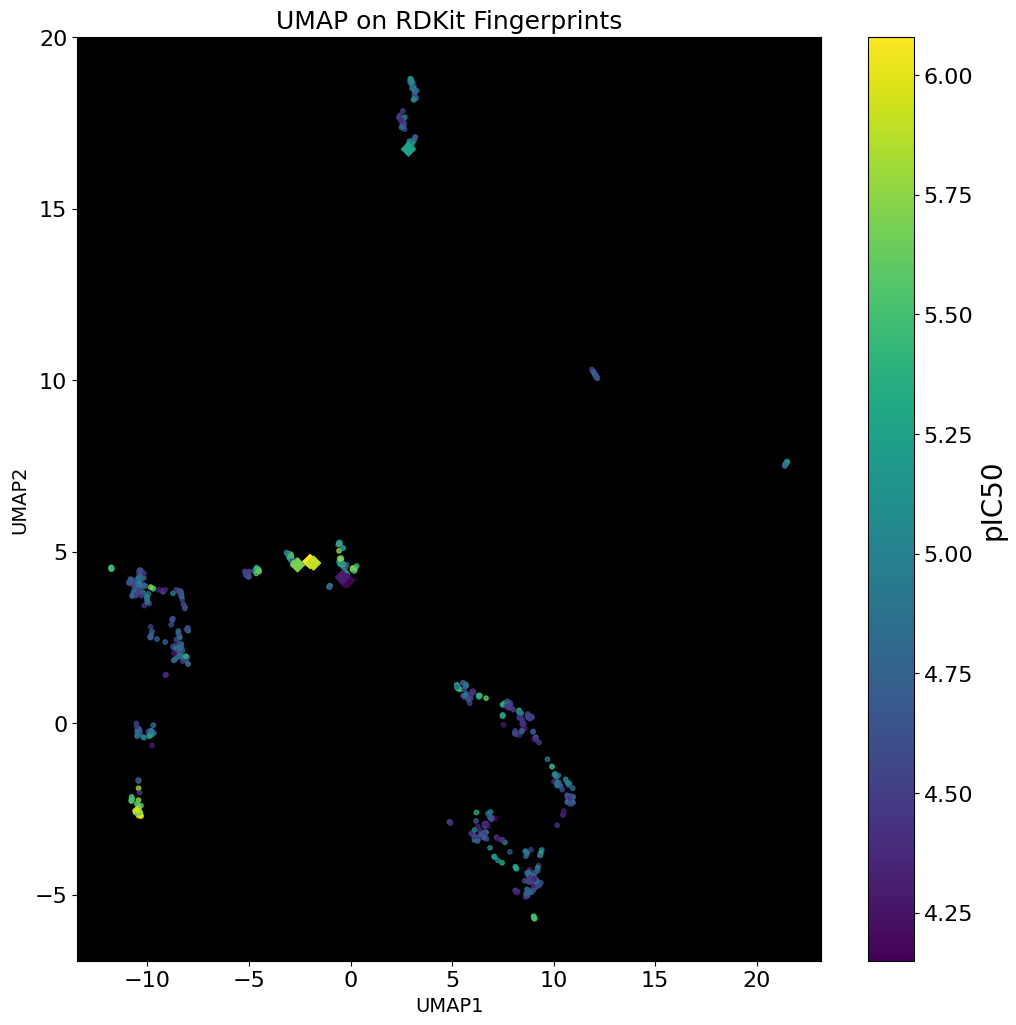

In [139]:
umap_rdkit = mapper.fit(X_rdkit)
X_rdkit_umap = umap_rdkit.transform(X_rdkit)

X_synth_rdkit_umap = umap_rdkit.transform(X_synth_rdkit)

plt.figure(figsize=(12,12))
ax = plt.gca()
plt.scatter(X_rdkit_umap[:,0], X_rdkit_umap[:,1], c=y, cmap="viridis", alpha=0.75, s=10)
plt.scatter(X_synth_rdkit_umap[:,0], X_synth_rdkit_umap[:,1], c=synth['IC50'].tolist(), cmap='viridis', marker='D', s=50)
plt.title("UMAP on RDKit Fingerprints",size=18)
plt.xlabel("UMAP1",size=14); plt.ylabel("UMAP2",size=14)
#plt.ylim(-10, 10)
ax.set_facecolor('black')
plt.colorbar(label="pIC50")
plt.show()

In [141]:
synth_morgan = prepare_df_morgan(synth, 2, 1024)
synth_morgan = synth_morgan.drop(columns=['IC50', 'pIC50'])
X_synth_morgan = synth_morgan['Fingerprint']
X_synth_morgan = X_synth_morgan.tolist()
X_synth_morgan = np.array(X_synth_morgan)
scaler=StandardScaler()
X_synth_morgan = scaler.fit_transform(X_synth_morgan)
X_synth_morgan.shape

(7, 1024)

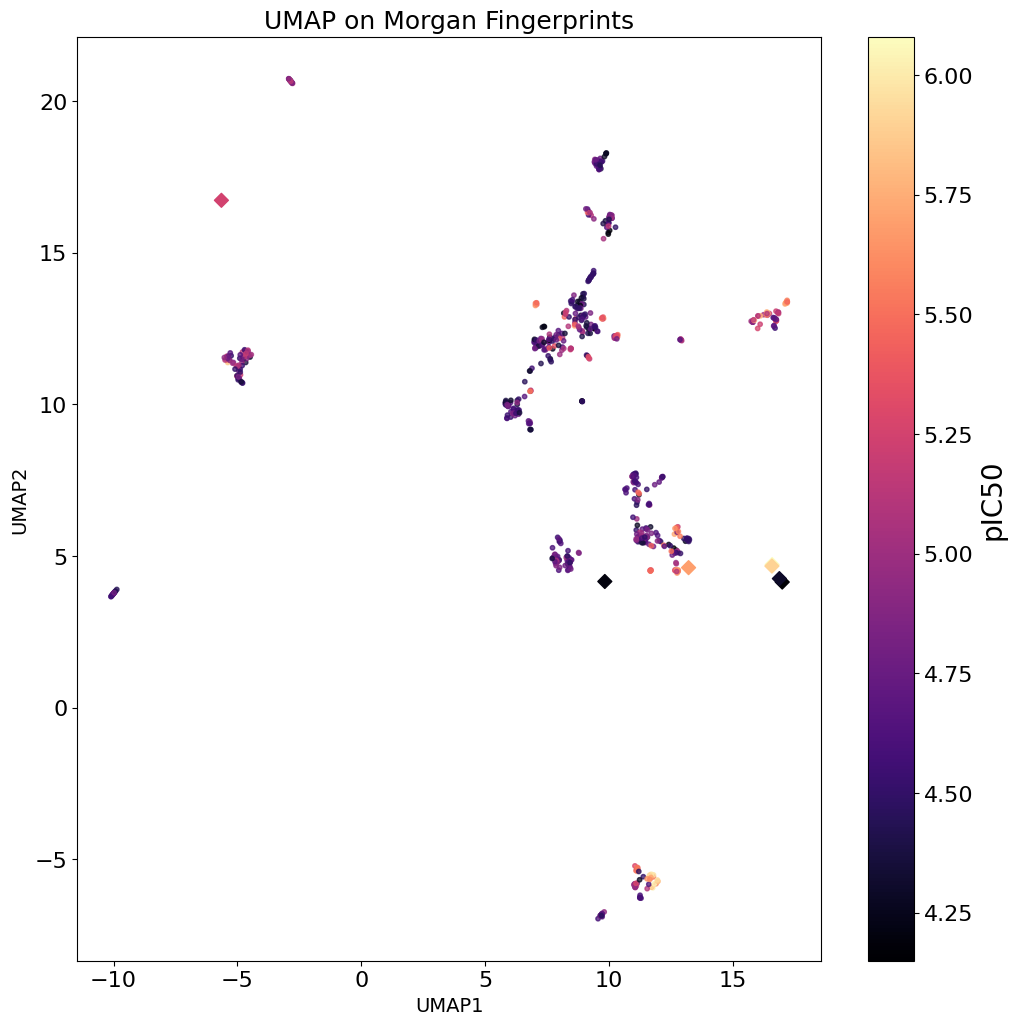

In [158]:
umap_morgan = mapper.fit(X_morgan)
X_morgan_umap = umap_morgan.transform(X_morgan)

X_synth_morgan_umap = umap_morgan.transform(X_synth_morgan)

plt.figure(figsize=(12,12))
ax = plt.gca()
plt.scatter(X_morgan_umap[:,0], X_morgan_umap[:,1], c=y, cmap="magma", alpha=0.75, s=10)
plt.scatter(X_synth_morgan_umap[:,0], X_synth_rdkit_umap[:,1], c=synth['IC50'].tolist(), cmap='magma', marker='D', s=50)
plt.title("UMAP on Morgan Fingerprints",size=18)
plt.xlabel("UMAP1",size=14); plt.ylabel("UMAP2",size=14)
#plt.ylim(-10, 10)
ax.set_facecolor('white')
plt.colorbar(label="pIC50")
plt.show()

In [144]:
synth_chemeleon = prepare_df_chemeleon(synth)
synth_chemeleon = synth_chemeleon.drop(columns=['IC50', 'pIC50'])
X_synth_chemeleon = synth_chemeleon['Descriptors']
X_synth_chemeleon = X_synth_chemeleon.tolist()
X_synth_chemeleon = np.array(X_synth_chemeleon)
scaler=StandardScaler()
X_synth_chemeleon = scaler.fit_transform(X_synth_chemeleon)
X_synth_chemeleon.shape

(7, 6144)

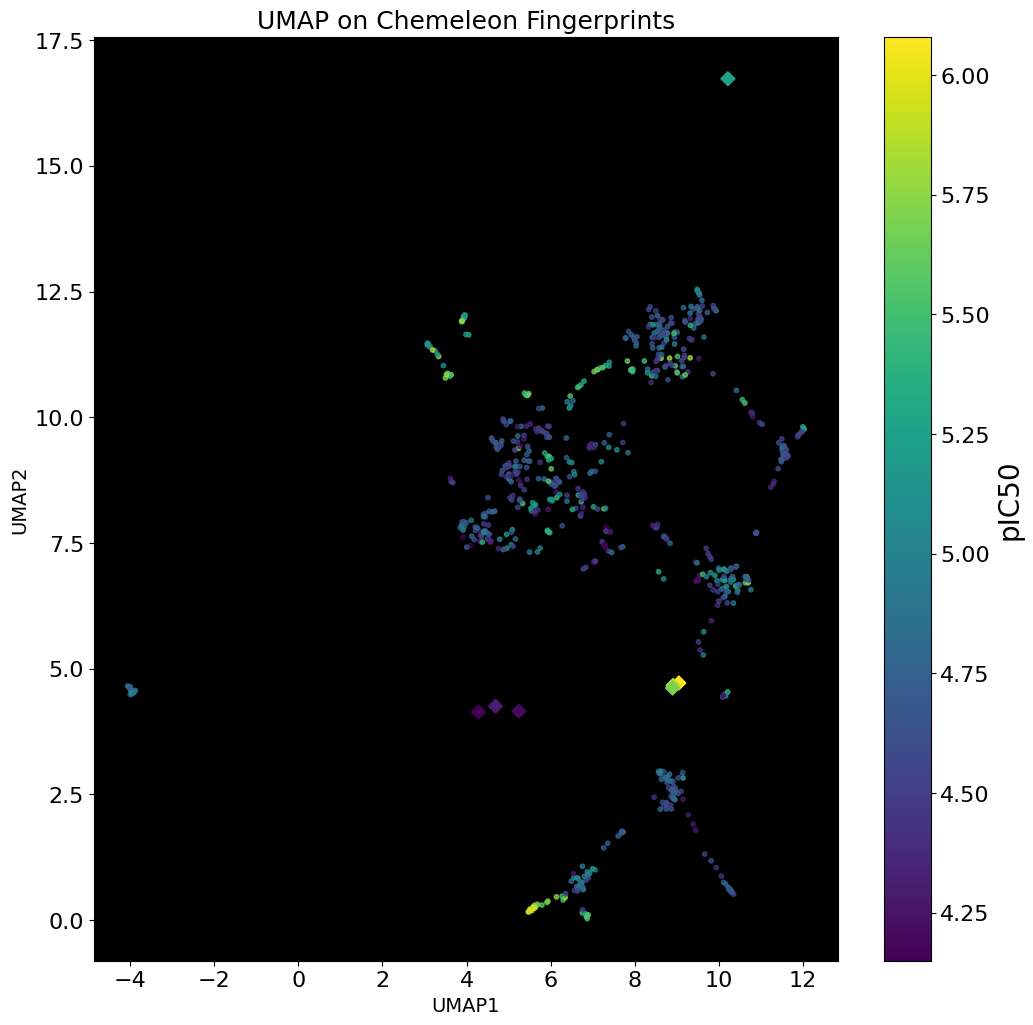

In [146]:
umap_chemeleon = mapper.fit(X_chemeleon)
X_chemeleon_umap = umap_chemeleon.transform(X_chemeleon)

X_synth_chemeleon_umap = umap_chemeleon.transform(X_synth_chemeleon)

plt.figure(figsize=(12,12))
ax = plt.gca()
plt.scatter(X_chemeleon_umap[:,0], X_chemeleon_umap[:,1], c=y, cmap="viridis", alpha=0.75, s=10)
plt.scatter(X_synth_chemeleon_umap[:,0], X_synth_rdkit_umap[:,1], c=synth['IC50'].tolist(), cmap='viridis', marker='D', s=50)
plt.title("UMAP on Chemeleon Fingerprints",size=18)
plt.xlabel("UMAP1",size=14); plt.ylabel("UMAP2",size=14)
#plt.ylim(-10, 10)
ax.set_facecolor('black')
plt.colorbar(label="pIC50")
plt.show()

# UMAP on combined training, generated and synthesized datasets

## Descriptors

In [16]:
import umap
import matplotlib as mpl

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'   # only needed in extreme cases
np.random.seed(42)
mapper = umap.UMAP(
    n_neighbors=5,
    min_dist=0.1,
    metric='euclidean',
    random_state=42,   # essential for reproducibility
    init='spectral',   # good deterministic-ish init (still uses random_state)
    n_jobs=1           # single thread lowers nondeterminism (slower)
)

In [13]:
gen_desc = pd.read_csv('generated_200k.csv')

In [14]:
import re
def parse_array_string(s):
    if pd.isna(s):
        return np.array([])           # or return np.nan if you prefer
    # replace newlines and repeated whitespace with single space, remove brackets
    clean = re.sub(r"[\[\]\n]+", " ", str(s)).strip()
    if clean == "":
        return np.array([])
    return np.fromstring(clean, sep=" ")

In [15]:
gen_desc['Descriptors'] = gen_desc['Descriptors'].apply(parse_array_string)

In [14]:
synth = pd.read_csv('synthesized_complexes.csv')

In [17]:
og_gen = gen_desc.copy()

In [18]:
og_synth = synth.copy()

In [19]:
train_desc = metals_desc.copy()
df_umap_desc=[]

synth['IC50'] = [5.25, 4.20, 4.15, 6.08, 5.90, 4.30, 5.69]
synth_desc = prepare_df_rdkit(synth)
synth_desc = calc_desc(synth_desc)

train_desc['Descriptors'] = train_desc['Descriptors'].apply(lambda x: x.tolist())
train_desc['Dataset'] = 't'
train_desc = train_desc[['Descriptors', 'Dataset']]
df_umap_desc.append(train_desc)

synth_desc['Descriptors'] = synth_desc['Descriptors'].apply(lambda x: x.tolist())
synth_desc['Dataset'] = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
synth_desc = synth_desc[['Descriptors', 'Dataset']]
df_umap_desc.append(synth_desc)

#gen_desc['Descriptors'] = gen_desc['Descriptors'].apply(lambda x: x.tolist())
gen_desc = gen_desc[['Descriptors']]
gen_desc['Dataset'] = 'g'
gen_desc = gen_desc[['Descriptors', 'Dataset']]
df_umap_desc.append(gen_desc)

total_df_desc = pd.concat(df_umap_desc, ignore_index=True, axis=0)
#total_df_desc = total_df_desc.dropna()

#X = total_df_desc['Descriptors']

#X = X[X.apply(lambda arr: not np.isnan(arr).any())]
#X= X.tolist()
#X = np.array(X)
scaler = StandardScaler()
#X = scaler.fit_transform(X)

total_df_desc['Descriptors'] = scaler.fit_transform(np.array(total_df_desc['Descriptors'].tolist()))
total_df_desc = total_df_desc.dropna(how='any')

print(f'length of total_df_desc : {len(total_df_desc)}')

X = pd.DataFrame(total_df_desc['Descriptors'])
print(f'lenght of X : {len(X)}')
X_umap = mapper.fit_transform(X)
X_umap = pd.DataFrame(X_umap)

X_umap.columns = ['UMAP1', 'UMAP2']

X_umap['Dataset'] = total_df_desc['Dataset']
print(f'length of X_umap : {len(X_umap)}')

#total_umap['UMAP1'] = total_umap['UMAP1'].apply(json.dumps)
#total_umap['UMAP2'] = total_umap['UMAP2'].apply(json.dumps)
#total_umap.to_csv('UMAP_Chemeleon.csv')


length of total_df_desc : 200690
lenght of X : 200690


C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\umap\spectral.py:5

length of X_umap : 200690


In [20]:
X_umap[X_umap['Dataset'].isin(['A', 'B', 'C', 'D', 'E', 'F', 'G'])]

UMAP1     UMAP2 Dataset
718   6.781508  0.100073       A
719  11.197481  0.308642       B
720  13.153922  3.020062       C
721  -0.787096  0.361421       D
722  -6.651229 -3.670846       E
723  10.014095  0.064801       F
724   3.939009  0.953226       G

In [21]:
X_umap_gen = X_umap[X_umap['Dataset'] == 'g']
X_umap_train = X_umap[X_umap['Dataset'] == 't']
X_umap_synth = X_umap[X_umap['Dataset'].isin(['A', 'B', 'C', 'D', 'E', 'F', 'G'])]

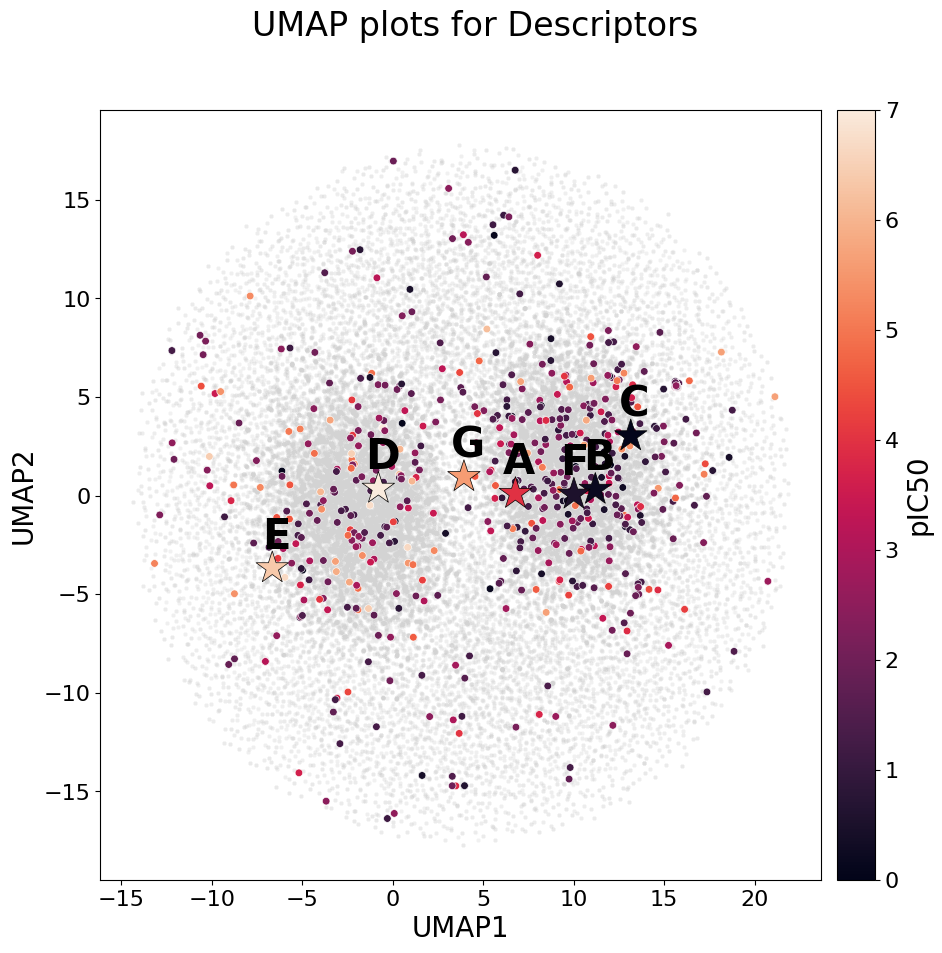

In [27]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

fig.suptitle('UMAP plots for Descriptors')
cmap = sns.color_palette('rocket', as_cmap=True)

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

for (x, y), label in zip(X_umap_synth[['UMAP1','UMAP2']].values, letters):
    if label == 'F':
        axes.text(
            x+0.05,
            y+1.6,
            label,
            fontsize=30,
            fontweight='bold',
            ha='center',
            va='center',
            color='black',
            zorder=10
        )
    else:
        axes.text(
            x+0.2,
            y+1.6,
            label,
            fontsize=30,
            fontweight='bold',
            ha='center',
            va='center',
            color='black',
            zorder=10
        )


sns.scatterplot(ax=axes, data=X_umap_gen, x='UMAP1', y='UMAP2', s=8, alpha=0.05, color='lightgray', legend=False)
sns.scatterplot(ax=axes, data=X_umap_train, x='UMAP1', y='UMAP2', hue=metals_desc['pIC50'], palette=cmap, legend=False, s=30)
sns.scatterplot(ax=axes, data = X_umap_synth, x='UMAP1', y='UMAP2', marker='*', s=600, edgecolor='black', linewidth=0.5, hue=synth['IC50'].tolist(), palette=cmap, legend=False)

#plt.xlim(-20,20)
#plt.ylim(-20,20)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=7))
sm.set_array([])  # required for colorbar
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.05, pad=0.02)
cbar.set_label('pIC50')

plt.savefig('UMAP_200k_descriptors.png', dpi=300)

## RDKit FP

In [7]:
gen_rdkit = pd.read_csv('dataset_encoded_to_RDKit_FP.csv')

In [8]:
import json
gen_rdkit['Fingerprint'] = gen_rdkit['Fingerprint'].apply(json.loads)

#gen_rdkit = np.stack(gen_rdkit.values)

#gen_rdkit.shape


In [9]:
gen_rdkit

L1                      L2  \
0       c1cnc2c(c1)ccc1cccnc12  c1cnc2c(c1)ccc1cccnc12   
1          c1ccc(-c2ccccn2)nc1     c1ccc(-c2ccccn2)nc1   
2          c1ccc(-c2ccccn2)nc1     c1ccc(-c2ccccn2)nc1   
3       c1cnc2c(c1)ccc1cccnc12  c1cnc2c(c1)ccc1cccnc12   
4       c1cnc2c(c1)ccc1cccnc12  c1cnc2c(c1)ccc1cccnc12   
...                        ...                     ...   
186068     c1ccc(-c2ccccn2)nc1     c1ccc(-c2ccccn2)nc1   
186069     c1ccc(-c2ccccn2)nc1     c1ccc(-c2ccccn2)nc1   
186070     c1ccc(-c2ccccn2)nc1     c1ccc(-c2ccccn2)nc1   
186071     c1ccc(-c2ccccn2)nc1     c1ccc(-c2ccccn2)nc1   
186072  c1cnc2c(c1)ccc1cccnc12  c1cnc2c(c1)ccc1cccnc12   

                                                       L3      ID  \
0               CC(C)(C(=O)O)c1ccc(-c2ccc(O)c3ncccc23)cc1       0   
1                    CCO[C@H](C)C(=O)NCc1ccnc(-n2cccn2)c1       1   
2       CCOC(=O)COc1c(OC)cc(C=Nn2c(-c3ccccc3)nc3ccccc3...       2   
3                      O=c1c2ccccc2ncn1/N=C/c1c(F)cccc1Cl       3   
4                                         Oc1cccc2cccnc12       4   
...                                                   ...     ...   
186068  COc1cccc2c1OCc1cn(nn1)[C@@H]1CN(C(=O)c3cnn(-c4...  199995   
186069  COc1cc(Cl)cc(C=Nn2c(C3CCCCC3)nc3ccccc3c2=O)c1O...  199996   
186070  CCOC(=O)Cc1ccc(-n2c3cnccc3c3cnc(Nc4ccc(N5CCN(C...  199997   
186071                    CCOC1(O)C(=O)c2cccnc2-c2ncccc21  199998   
186072                  CC(N)Cc1ccc(-c2ccc(CC(C)N)cn2)nc1  199999   

                                              Fingerprint  
0       [3, 1, 0, 1, 0, 3, 0, 0, 0, 0, 0, 3, 1, 0, 1, ...  
1       [3, 2, 0, 0, 0, 3, 0, 2, 0, 0, 1, 3, 0, 0, 0, ...  
2       [3, 3, 1, 0, 0, 3, 1, 3, 0, 1, 0, 2, 0, 1, 0, ...  
3       [3, 0, 1, 0, 0, 3, 0, 0, 0, 1, 0, 2, 0, 0, 0, ...  
4       [3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, ...  
...                                                   ...  
186068  [3, 3, 1, 1, 1, 3, 0, 2, 1, 0, 1, 3, 1, 1, 1, ...  
186069  [3, 2, 1, 1, 0, 3, 0, 3, 1, 1, 0, 2, 0, 1, 0, ...  
186070  [3, 2, 1, 1, 0, 3, 1, 3, 1, 0, 0, 3, 1, 0, 0, ...  
186071  [3, 3, 0, 1, 1, 3, 0, 3, 1, 0, 1, 3, 0, 0, 0, ...  
186072  [3, 1, 0, 0, 0, 3, 0, 1, 1, 0, 0, 3, 0, 0, 0, ...  

[186073 rows x 5 columns]

In [10]:
train_rdkit = metals_rdkit.copy()

In [15]:
df_umap_rdkit=[]

synth['IC50'] = [5.25, 4.20, 4.15, 6.08, 5.90, 4.30, 5.69]
synth_rdkit = prepare_df_rdkit(synth)


#train_rdkit['Fingerprint'] = train_rdkit['Fingerprint'].apply(lambda x: x.tolist())
train_rdkit['Dataset'] = 't'
train_rdkit = train_rdkit[['Fingerprint', 'Dataset']]
df_umap_rdkit.append(train_rdkit)

#synth_rdkit['Fingerprint'] = synth_rdkit['Fingerprint'].apply(lambda x: x.tolist())
synth_rdkit['Dataset'] = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
synth_rdkit = synth_rdkit[['Fingerprint', 'Dataset']]
df_umap_rdkit.append(synth_rdkit)

#gen_rdkit['Fingerprint'] = gen_rdkit['Fingerprint'].apply(lambda x: x.tolist())
gen_rdkit = gen_rdkit[['Fingerprint']]
gen_rdkit['Dataset'] = 'g'
gen_rdkit = gen_rdkit[['Fingerprint', 'Dataset']]
df_umap_rdkit.append(gen_rdkit)

total_df_rdkit = pd.concat(df_umap_rdkit, ignore_index=True, axis=0)
#total_df_rdkit = total_df_rdkit.dropna()
print(f'length of total_df : {len(total_df_rdkit)}')
scaler = StandardScaler()
#total_df_rdkit['Fingerprint'] = scaler.fit_transform(np.array(total_df_rdkit['Fingerprint'].tolist()))

#X = pd.DataFrame(total_df_rdkit['Fingerprint'])
X = np.array(total_df_rdkit['Fingerprint'].tolist())
print(f'length of X : {len(X)}')

X_umap = mapper.fit_transform(X)
X_umap = pd.DataFrame(X_umap)

X_umap.columns = ['UMAP1', 'UMAP2']

X_umap['Dataset'] = total_df_rdkit['Dataset']
print(f'length of X_umap : {len(X_umap)}')

#total_umap['UMAP1'] = total_umap['UMAP1'].apply(json.dumps)
#total_umap['UMAP2'] = total_umap['UMAP2'].apply(json.dumps)
#total_umap.to_csv('UMAP_Chemeleon.csv')


C:\Users\bparm\AppData\Local\Temp\ipykernel_5700\1280611357.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen_rdkit['Dataset'] = 'g'


length of total_df : 186798
length of X : 186798


C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 118 with accuracies 
[2.00563280e-05 9.44214065e-06 1.36381542e-05 4.32582600e-04]
not reaching the requested tolerance 1.6629695892333984e-05.
Use iteration 118 instead with accuracy 
0.00011892980580975532.

  _, diffusion_map = lobpcg(
C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.00563282e-05 9.44214022e-06 1.36381542e-05 4.32582600e-04]
not reaching the requested tolerance 1.6629695892333984e-05.
  _, diffusion_map = lobpcg(


length of X_umap : 186798


In [16]:
X_umap_gen_rdkit = X_umap[X_umap['Dataset'] == 'g']
X_umap_train_rdkit = X_umap[X_umap['Dataset'] == 't']
X_umap_synth_rdkit = X_umap[X_umap['Dataset'].isin(['A', 'B', 'C', 'D', 'E', 'F', 'G'])]

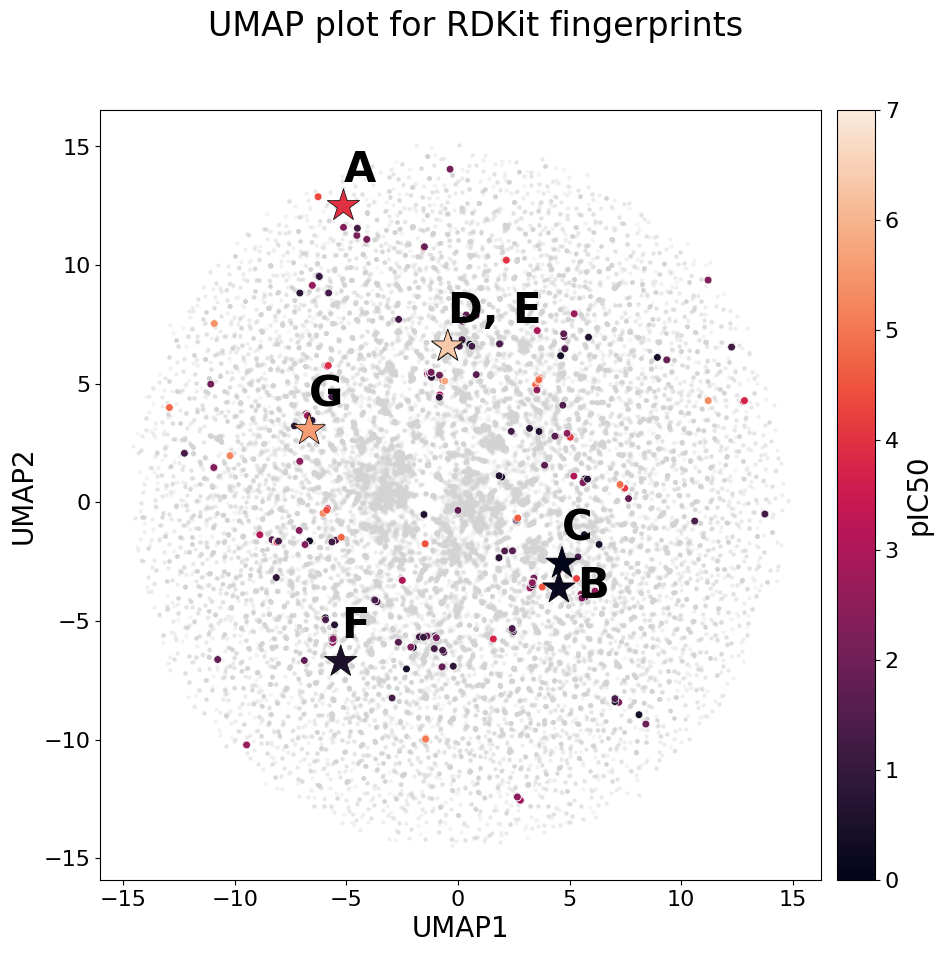

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

fig.suptitle('UMAP plot for RDKit fingerprints')
cmap = sns.color_palette('rocket', as_cmap=True)

letters = ['A', 'B', 'C', 'D, E', '', 'F', 'G']

for (x, y), label in zip(X_umap_synth_rdkit[['UMAP1','UMAP2']].values, letters):
    if label=='B':
        axes.text(
        x+0.8,
        y+0.1,
        label,
        fontsize=30,
        fontweight='bold',
        ha='left',
        va='center',
        color='black',      # choose your color
        zorder=10
    )
    else:
        axes.text(
            x+0,
            y+1.5,
            label,
            fontsize=30,
            fontweight='bold',
            ha='left',
            va='center',
            color='black',      # choose your color
            zorder=10
        )


sns.scatterplot(ax=axes, data=X_umap_gen_rdkit, x='UMAP1', y='UMAP2', s=8, alpha=0.05, color='lightgray', legend=False)
sns.scatterplot(ax=axes, data=X_umap_train_rdkit, x='UMAP1', y='UMAP2', hue=metals_desc['pIC50'], palette=cmap, legend=False, s=30)
sns.scatterplot(ax=axes, data = X_umap_synth_rdkit, x='UMAP1', y='UMAP2', marker='*', s=600, edgecolor='black', linewidth=0.5, hue=synth['IC50'].tolist(), palette=cmap, legend=False)

#plt.xlim(-20,20)
#plt.ylim(-20,20)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=7))

sm.set_array([])  # required for colorbar
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.05, pad=0.02)
cbar.set_label('pIC50')

plt.savefig('UMAP_200k_rdkit.png', dpi=300)

In [ ]:
del gen_desc, gen_rdkit
del total_df_desc, total_df_rdkit
del X_umap
del X_umap_gen, X_umap_gen_rdkit

## Morgan FP

In [6]:
gen_morgan = pd.read_csv('dataset_encoded_to_Morgan_FP.csv')

In [7]:
import json
gen_morgan['Fingerprint'] = gen_morgan['Fingerprint'].apply(json.loads)

In [8]:
train_morgan = metals_morgan.copy()

In [9]:
synth = pd.read_csv('synthesized_complexes.csv')

In [13]:
df_umap_morgan=[]

synth['IC50'] = [5.25, 4.20, 4.15, 6.08, 5.90, 4.30, 5.69]
synth_morgan = prepare_df_morgan(synth, 2, 1024)


#train_morgan['Fingerprint'] = train_morgan['Fingerprint'].apply(lambda x: x.tolist())
train_morgan['Dataset'] = 't'
train_morgan = train_morgan[['Fingerprint', 'Dataset']]
df_umap_morgan.append(train_morgan)

#synth_morgan['Fingerprint'] = synth_morgan['Fingerprint'].apply(lambda x: x.tolist())
synth_morgan['Dataset'] = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
synth_morgan = synth_morgan[['Fingerprint', 'Dataset']]
df_umap_morgan.append(synth_morgan)

#gen_morgan['Fingerprint'] = gen_morgan['Fingerprint'].apply(lambda x: x.tolist())
gen_morgan = gen_morgan[['Fingerprint']]
gen_morgan['Dataset'] = 'g'
gen_morgan = gen_morgan[['Fingerprint', 'Dataset']]
df_umap_morgan.append(gen_morgan)

total_df_morgan = pd.concat(df_umap_morgan, ignore_index=True, axis=0)
#total_df_morgan = total_df_morgan.dropna()
print(f'length of total_df : {len(total_df_morgan)}')
X = total_df_morgan['Fingerprint']

#X = X[X.apply(lambda arr: not np.isnan(arr).any())]
X= X.tolist()
X = np.array(X, dtype=np.float32)
scaler = StandardScaler()
#X = scaler.fit_transform(X)
print(f'length of X : {len(X)}')

X_umap = mapper.fit_transform(X)
X_umap = pd.DataFrame(X_umap)

X_umap.columns = ['UMAP1', 'UMAP2']

X_umap['Dataset'] = total_df_morgan['Dataset']
print(f'length of X_umap : {len(X_umap)}')

#total_umap['UMAP1'] = total_umap['UMAP1'].apply(json.dumps)
#total_umap['UMAP2'] = total_umap['UMAP2'].apply(json.dumps)
#total_umap.to_csv('UMAP_Chemeleon.csv')


length of total_df : 202978
length of X : 202978


C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\bparm\anaconda3\envs\ml_ru_chemeleon\Lib\site-packages\umap\spectral.py:5

length of X_umap : 202978


In [14]:
X_umap_gen_morgan = X_umap[X_umap['Dataset'] == 'g']
X_umap_train_morgan = X_umap[X_umap['Dataset'] == 't']
X_umap_synth_morgan = X_umap[X_umap['Dataset'].isin(['A', 'B', 'C', 'D', 'E', 'F', 'G'])]

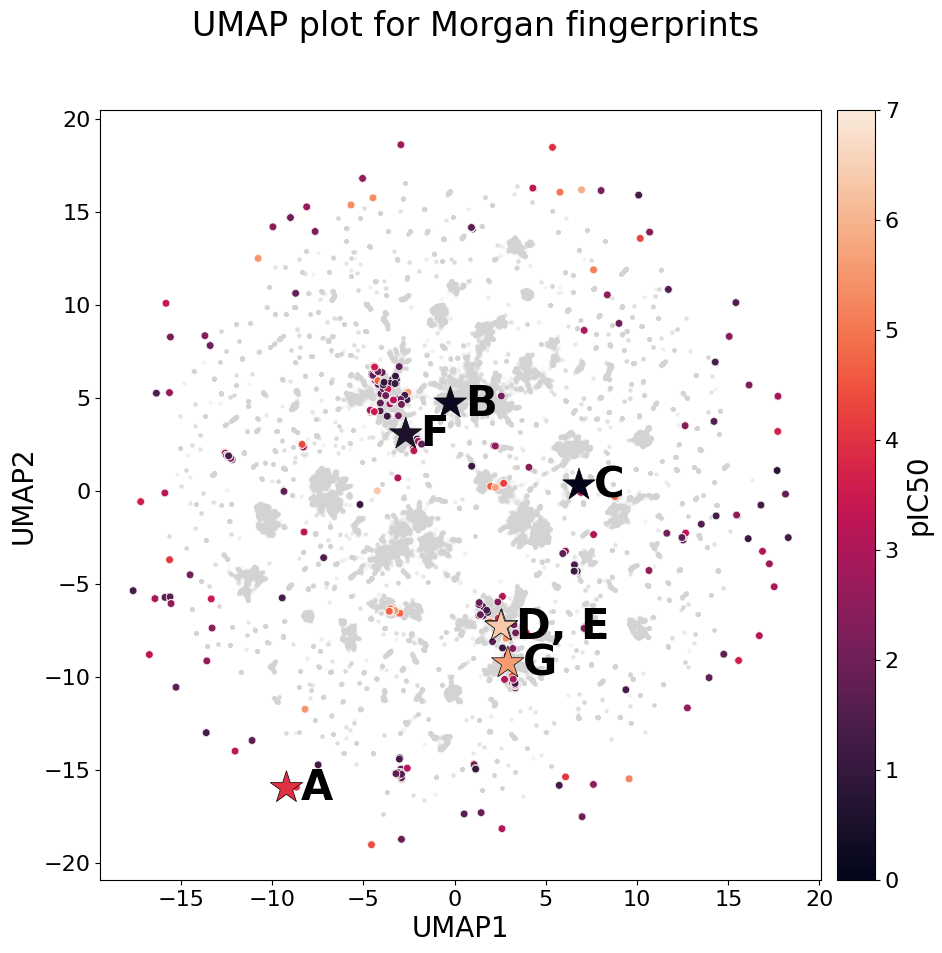

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

fig.suptitle('UMAP plot for Morgan fingerprints')
cmap = sns.color_palette('rocket', as_cmap=True)

letters = ['A', 'B', 'C', '', 'D, E', 'F', 'G']

i=0
for (x, y), label in zip(X_umap_synth_morgan[['UMAP1','UMAP2']].values, letters):
        axes.text(x+0.8, y+0, label, fontsize=30, fontweight='bold', ha='left', va='center', color='black', zorder=10)
        i+=1


sns.scatterplot(ax=axes, data=X_umap_gen_morgan, x='UMAP1', y='UMAP2', s=8, alpha=0.05, color='lightgray', legend=False)
sns.scatterplot(ax=axes, data=X_umap_train_morgan, x='UMAP1', y='UMAP2', hue=metals_rdkit['pIC50'], palette=cmap, legend=False, s=30)
sns.scatterplot(ax=axes, data = X_umap_synth_morgan, x='UMAP1', y='UMAP2', marker='*', s=600, edgecolor='black', linewidth=0.5 , hue=synth['IC50'].tolist(), palette=cmap, legend=False)

#plt.xlim(-20,20)
#plt.ylim(-20,20)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=7))

sm.set_array([])  # required for colorbar
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.05, pad=0.02)
cbar.set_label('pIC50')

plt.savefig('UMAP_200k_morgan.png', dpi=300)

## Chemeleon

In [19]:
total_df_chemeleon = pd.read_csv('./UMAP/UMAP_Chemeleon.csv')

In [20]:
total_df_chemeleon

Unnamed: 0      UMAP1      UMAP2                Dataset
0                0   5.090503   6.037961                      g
1                1   3.380790  -5.876130                      g
2                2  -2.360268  -8.971880                      g
3                3   1.850560  11.552992                      g
4                4  17.198399  -4.522576                      g
...            ...        ...        ...                    ...
200720      200720   2.062485  -1.598355  [A, B, C, D, E, F, G]
200721      200721   5.938462   6.799067  [A, B, C, D, E, F, G]
200722      200722   1.651109  11.393992  [A, B, C, D, E, F, G]
200723      200723   2.943849  -3.423988  [A, B, C, D, E, F, G]
200724      200724   5.168033   5.683978  [A, B, C, D, E, F, G]

[200725 rows x 4 columns]

In [21]:
X_umap = total_df_chemeleon[['UMAP1', 'UMAP2', 'Dataset']]

In [22]:
X_umap_gen_chemeleon = X_umap[X_umap['Dataset'] == 'g']
X_umap_train_chemeleon = X_umap[X_umap['Dataset'] == 't']
X_umap_synth_chemeleon = X_umap[X_umap['Dataset']=='[A, B, C, D, E, F, G]']

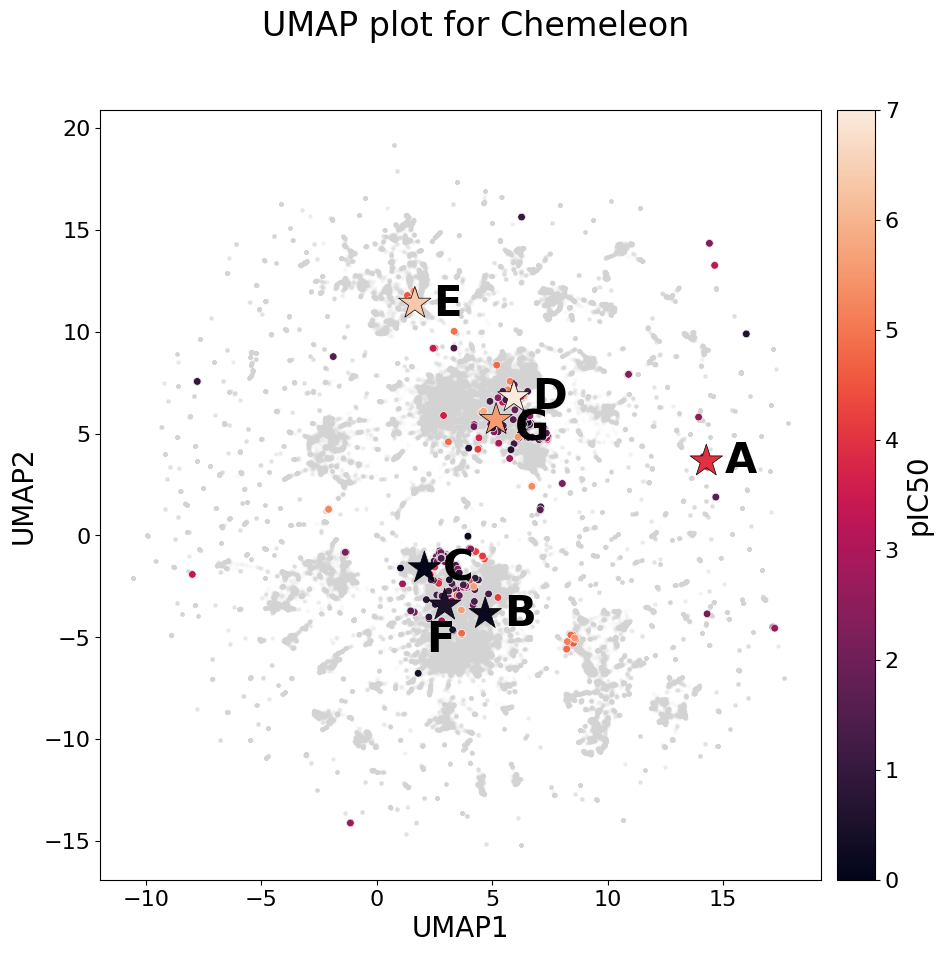

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

fig.suptitle('UMAP plot for Chemeleon')
cmap = sns.color_palette('rocket', as_cmap=True)

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

for (x, y), label in zip(X_umap_synth_chemeleon[['UMAP1','UMAP2']].values, letters):
    if label == 'F':
        axes.text(
            x-0.8,
            y-1.7,
            label,
            fontsize=30,
            fontweight='bold',
            ha='left',
            va='center',
            color='black',      # choose your color
            zorder=10
        )

    elif label == 'G':
        axes.text(
            x+0.8,
            y-0.4,
            label,
            fontsize=30,
            fontweight='bold',
            ha='left',
            va='center',
            color='black',      # choose your color
            zorder=10
        )

    else:
        axes.text(
            x+0.8,
            y,
            label,
            fontsize=30,
            fontweight='bold',
            ha='left',
            va='center',
            color='black',      # choose your color
            zorder=10
        )

sns.scatterplot(ax=axes, data=X_umap_gen_chemeleon, x='UMAP1', y='UMAP2', s=8, alpha=0.05, color='lightgray', legend=False)
sns.scatterplot(ax=axes, data=X_umap_train_chemeleon, x='UMAP1', y='UMAP2', hue=metals_rdkit['pIC50'].tolist(), palette=cmap, legend=False, s=30)
sns.scatterplot(ax=axes, data = X_umap_synth_chemeleon, x='UMAP1', y='UMAP2', marker='*', s=600, edgecolor='black', linewidth=0.5, hue=synth['IC50'].tolist(), palette=cmap, legend=False)

#plt.xlim(-20,20)
#plt.ylim(-20,20)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=7))

sm.set_array([])  # required for colorbar
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.05, pad=0.02)
cbar.set_label('pIC50')

plt.savefig('UMAP_200k_chemeleon.png', dpi=300)